In [5]:
from google.colab import drive
drive.mount('/content/drive')

import os
import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from typing import Dict, List, Tuple, Optional
import logging

# Machine Learning Libraries
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    precision_recall_fscore_support, classification_report,
    confusion_matrix
)
from sklearn.metrics.pairwise import cosine_similarity

# BERT and Transformers (if available)
try:
    from transformers import AutoTokenizer, AutoModel
    import torch
    TRANSFORMERS_AVAILABLE = True
except ImportError:
    print("⚠️ Transformers not available. Install with: pip install transformers torch")
    TRANSFORMERS_AVAILABLE = False

import warnings
warnings.filterwarnings('ignore')

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Evaluasi Retrieval**

In [6]:
# ============================================================================
# i. EVALUASI RETRIEVAL
# 1. Ukur Accuracy, Precision, Recall, F1-score
# 2. Gunakan sklearn.metrics
# 3. Implementasi def eval_retrieval(queries, ground_truth, k)
# ============================================================================

class RetrievalEvaluator:
    """
    i. Evaluasi Retrieval dengan metrics standar
    """

    def __init__(self, base_dir="/content/drive/MyDrive/terorisme"):
        self.base_dir = base_dir
        self.eval_dir = os.path.join(base_dir, "data", "eval")
        self.vectors_dir = os.path.join(base_dir, "data", "vectors")
        self.models_dir = os.path.join(base_dir, "data", "models")

        # Create eval directory
        os.makedirs(self.eval_dir, exist_ok=True)

        print("📊 i. EVALUASI RETRIEVAL")

        # Load components
        self.retrieval_systems = {}
        self.load_retrieval_systems()

    def load_retrieval_systems(self):
        """Load multiple retrieval systems untuk comparison"""
        print("\n🔧 Loading retrieval systems...")

        # 1. TF-IDF System
        try:
            self.retrieval_systems['tfidf'] = TFIDFRetrievalSystem(self.base_dir)
            print("✅ TF-IDF system loaded")
        except Exception as e:
            print(f"❌ TF-IDF system failed: {e}")

        # 2. BERT System (if available)
        if TRANSFORMERS_AVAILABLE:
            try:
                self.retrieval_systems['bert'] = BERTRetrievalSystem(self.base_dir)
                print("✅ BERT system loaded")
            except Exception as e:
                print(f"❌ BERT system failed: {e}")

        # 3. SVM System (FIXED - should work if models exist)
        try:
            self.retrieval_systems['svm'] = SVMRetrievalSystem(self.base_dir)
            print("✅ SVM system loaded")
        except Exception as e:
            print(f"❌ SVM system failed: {e}")
            print(f"   Reason: {str(e)}")
            # Try to create fallback SVM system
            try:
                self.retrieval_systems['svm'] = SVMFallbackSystem(self.base_dir)
                print("✅ SVM fallback system loaded")
            except Exception as e2:
                print(f"❌ SVM fallback also failed: {e2}")

        # 4. ADDED: Naive Bayes System
        try:
            self.retrieval_systems['naive_bayes'] = NaiveBayesRetrievalSystem(self.base_dir)
            print("✅ Naive Bayes system loaded")
        except Exception as e:
            print(f"❌ Naive Bayes system failed: {e}")

        print(f"📊 Total systems loaded: {len(self.retrieval_systems)}")
        if self.retrieval_systems:
            print(f"✅ Available systems: {list(self.retrieval_systems.keys())}")
        else:
            print("❌ No retrieval systems loaded! Check previous stages.")

    def load_test_queries(self) -> Tuple[List[Dict], bool]:
        """Load test queries from queries.json"""
        queries_file = os.path.join(self.eval_dir, "queries.json")

        if not os.path.exists(queries_file):
            print("❌ queries.json not found. Run Tahap 4 first.")
            return [], False

        try:
            with open(queries_file, 'r', encoding='utf-8') as f:
                queries_data = json.load(f)

            test_queries = queries_data.get('queries', [])
            print(f"✅ Loaded {len(test_queries)} test queries")

            return test_queries, True

        except Exception as e:
            print(f"❌ Error loading queries: {e}")
            return [], False

    def calculate_retrieval_metrics(self, retrieved: List[str], ground_truth: List[str], k: int) -> Dict:
        """
        1. Ukur Accuracy, Precision, Recall, F1-score
        2. Gunakan sklearn.metrics
        """
        retrieved_set = set(retrieved[:k])
        ground_truth_set = set(ground_truth)

        # True Positives: relevant documents yang di-retrieve
        tp = len(retrieved_set & ground_truth_set)

        # False Positives: non-relevant documents yang di-retrieve
        fp = len(retrieved_set - ground_truth_set)

        # False Negatives: relevant documents yang tidak di-retrieve
        fn = len(ground_truth_set - retrieved_set)

        # True Negatives: untuk retrieval, biasanya tidak dihitung
        # karena universe of documents sangat besar

        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

        # Accuracy untuk retrieval = precision@k
        accuracy = precision

        return {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'accuracy': accuracy,
            'tp': tp,
            'fp': fp,
            'fn': fn,
            'retrieved_count': len(retrieved_set),
            'relevant_count': len(ground_truth_set)
        }

    def eval_retrieval(self, queries: List[Dict], ground_truth: Dict, k: int = 5) -> Dict:
        """
        3. Implementasi def eval_retrieval(queries, ground_truth, k)
        """
        print(f"\n📊 Evaluating retrieval performance with k={k}")

        results = {}

        for system_name, retrieval_system in self.retrieval_systems.items():
            print(f"\n🔍 Evaluating {system_name.upper()} system...")

            system_metrics = []
            query_results = []

            for query in queries:
                query_id = query['query_id']
                query_text = query['query_text']
                query_ground_truth = query.get('ground_truth', [])

                try:
                    # Retrieve documents
                    retrieved_docs = retrieval_system.retrieve(query_text, k=k)

                    # Calculate metrics untuk query ini
                    metrics = self.calculate_retrieval_metrics(
                        retrieved_docs, query_ground_truth, k
                    )

                    metrics['query_id'] = query_id
                    metrics['query_text'] = query_text
                    metrics['retrieved_docs'] = retrieved_docs
                    metrics['ground_truth'] = query_ground_truth

                    system_metrics.append(metrics)
                    query_results.append(metrics)

                    print(f"   {query_id}: P={metrics['precision']:.3f}, R={metrics['recall']:.3f}, F1={metrics['f1']:.3f}")

                except Exception as e:
                    print(f"   {query_id}: Error - {e}")

                    error_metrics = {
                        'query_id': query_id,
                        'query_text': query_text,
                        'precision': 0.0,
                        'recall': 0.0,
                        'f1': 0.0,
                        'accuracy': 0.0,
                        'error': str(e)
                    }

                    system_metrics.append(error_metrics)
                    query_results.append(error_metrics)

            # Calculate aggregate metrics
            valid_metrics = [m for m in system_metrics if 'error' not in m]

            if valid_metrics:
                avg_precision = np.mean([m['precision'] for m in valid_metrics])
                avg_recall = np.mean([m['recall'] for m in valid_metrics])
                avg_f1 = np.mean([m['f1'] for m in valid_metrics])
                avg_accuracy = np.mean([m['accuracy'] for m in valid_metrics])

                aggregate = {
                    'system': system_name,
                    'k': k,
                    'queries_evaluated': len(valid_metrics),
                    'avg_precision': avg_precision,
                    'avg_recall': avg_recall,
                    'avg_f1': avg_f1,
                    'avg_accuracy': avg_accuracy,
                    'std_precision': np.std([m['precision'] for m in valid_metrics]),
                    'std_recall': np.std([m['recall'] for m in valid_metrics]),
                    'std_f1': np.std([m['f1'] for m in valid_metrics])
                }

                print(f"📊 {system_name.upper()} Summary:")
                print(f"   Avg Precision: {avg_precision:.3f} ± {aggregate['std_precision']:.3f}")
                print(f"   Avg Recall: {avg_recall:.3f} ± {aggregate['std_recall']:.3f}")
                print(f"   Avg F1: {avg_f1:.3f} ± {aggregate['std_f1']:.3f}")

            else:
                aggregate = {
                    'system': system_name,
                    'k': k,
                    'queries_evaluated': 0,
                    'avg_precision': 0.0,
                    'avg_recall': 0.0,
                    'avg_f1': 0.0,
                    'avg_accuracy': 0.0,
                    'error': 'All queries failed'
                }

            results[system_name] = {
                'aggregate': aggregate,
                'query_results': query_results
            }

        return results

class TFIDFRetrievalSystem:
    """TF-IDF Retrieval System untuk evaluation"""

    def __init__(self, base_dir):
        self.base_dir = base_dir
        self.vectors_dir = os.path.join(base_dir, "data", "vectors")

        self.tfidf_vectorizer = None
        self.case_vectors = None
        self.case_ids = []

        self.load_components()

    def load_components(self):
        """Load TF-IDF components"""
        # Find best TF-IDF file
        vector_files = [f for f in os.listdir(self.vectors_dir) if f.endswith('.pkl')]
        tfidf_files = [f for f in vector_files if 'tfidf' in f.lower()]

        if not tfidf_files:
            raise Exception("No TF-IDF files found")

        # Use latest or enhanced file
        best_file = max(tfidf_files)

        with open(os.path.join(self.vectors_dir, best_file), 'rb') as f:
            data = pickle.load(f)

        self.tfidf_vectorizer = data['vectorizer']
        self.case_vectors = data['vectors']
        self.case_ids = data['case_ids']

        if hasattr(self.case_vectors, 'toarray'):
            self.case_vectors = self.case_vectors.toarray()

    def retrieve(self, query: str, k: int = 5) -> List[str]:
        """Retrieve using TF-IDF"""
        query_vector = self.tfidf_vectorizer.transform([query.lower()])

        if query_vector.nnz == 0:
            return []

        query_dense = query_vector.toarray() if hasattr(query_vector, 'toarray') else query_vector
        similarities = cosine_similarity(query_dense, self.case_vectors).flatten()

        top_indices = np.argsort(similarities)[::-1][:k]
        return [self.case_ids[idx] for idx in top_indices]

class BERTRetrievalSystem:
    """BERT Retrieval System untuk evaluation"""

    def __init__(self, base_dir):
        self.base_dir = base_dir
        self.vectors_dir = os.path.join(base_dir, "data", "vectors")

        self.bert_model_name = "indobenchmark/indobert-base-p1"
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.tokenizer = None
        self.model = None
        self.case_vectors = None
        self.case_ids = []

        self.load_components()

    def load_components(self):
        """Load BERT components"""
        # Load BERT model
        self.tokenizer = AutoTokenizer.from_pretrained(self.bert_model_name)
        self.model = AutoModel.from_pretrained(self.bert_model_name)
        self.model.to(self.device)
        self.model.eval()

        # Load BERT vectors
        vector_files = [f for f in os.listdir(self.vectors_dir) if f.endswith('.pkl')]
        bert_files = [f for f in vector_files if 'bert' in f.lower()]

        if not bert_files:
            raise Exception("No BERT files found")

        best_file = max(bert_files)

        with open(os.path.join(self.vectors_dir, best_file), 'rb') as f:
            data = pickle.load(f)

        self.case_vectors = data['vectors']
        self.case_ids = data['case_ids']

    def get_bert_embedding(self, text: str) -> np.ndarray:
        """Get BERT embedding for text"""
        inputs = self.tokenizer(
            text,
            max_length=512,
            padding=True,
            truncation=True,
            return_tensors='pt'
        )

        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.model(**inputs)
            embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()

        return embedding.flatten()

    def retrieve(self, query: str, k: int = 5) -> List[str]:
        """Retrieve using BERT"""
        query_vector = self.get_bert_embedding(query.lower())
        query_vector = query_vector.reshape(1, -1)

        similarities = cosine_similarity(query_vector, self.case_vectors).flatten()

        top_indices = np.argsort(similarities)[::-1][:k]
        return [self.case_ids[idx] for idx in top_indices]

class SVMRetrievalSystem:
    """SVM-enhanced Retrieval System untuk evaluation - FIXED"""

    def __init__(self, base_dir):
        self.base_dir = base_dir
        self.models_dir = os.path.join(base_dir, "data", "models")

        # Use TF-IDF as base with SVM enhancement
        self.tfidf_system = TFIDFRetrievalSystem(base_dir)
        self.svm_model = None
        self.scaler = None

        self.load_svm_model()

    def load_svm_model(self):
        """Load trained SVM model - FIXED with better error handling"""
        if not os.path.exists(self.models_dir):
            raise Exception(f"Models directory not found: {self.models_dir}")

        model_files = [f for f in os.listdir(self.models_dir) if f.startswith('ml_models_')]

        if not model_files:
            raise Exception("No ML models found. Run Tahap 3 first.")

        latest_model = max(model_files)
        model_path = os.path.join(self.models_dir, latest_model)

        try:
            with open(model_path, 'rb') as f:
                data = pickle.load(f)

            models = data.get('models', {})
            scalers = data.get('scalers', {})

            # Try different SVM model names
            svm_candidates = ['svm_rbf', 'svm_linear', 'svm']

            for candidate in svm_candidates:
                if candidate in models:
                    self.svm_model = models[candidate].get('model') if isinstance(models[candidate], dict) else models[candidate]
                    self.scaler = scalers.get('svm_tfidf') or scalers.get(f'{candidate}_scaler')
                    print(f"✅ Loaded SVM model: {candidate}")
                    return

            raise Exception(f"No SVM model found. Available models: {list(models.keys())}")

        except Exception as e:
            raise Exception(f"Error loading SVM model from {latest_model}: {e}")

    def retrieve(self, query: str, k: int = 5) -> List[str]:
        """Retrieve using SVM-enhanced method - FIXED"""
        if not self.svm_model:
            # Fallback to TF-IDF if SVM not available
            return self.tfidf_system.retrieve(query, k)

        try:
            # Get TF-IDF representation
            query_vector = self.tfidf_system.tfidf_vectorizer.transform([query.lower()])

            if query_vector.nnz == 0:
                return []

            # If scaler available, use it
            if self.scaler:
                query_dense = query_vector.toarray()
                query_scaled = self.scaler.transform(query_dense)
            else:
                query_scaled = query_vector.toarray()

            # Get SVM prediction/decision scores
            if hasattr(self.svm_model, 'decision_function'):
                # Use decision function for ranking
                case_vectors = self.tfidf_system.case_vectors

                if self.scaler and hasattr(case_vectors, 'toarray'):
                    case_dense = case_vectors.toarray() if hasattr(case_vectors, 'toarray') else case_vectors
                    case_scaled = self.scaler.transform(case_dense)
                    similarities = cosine_similarity(query_scaled, case_scaled).flatten()
                else:
                    # Fallback to regular cosine similarity
                    query_dense = query_vector.toarray()
                    similarities = cosine_similarity(query_dense, case_vectors).flatten()

                # Boost similarities with SVM confidence (if possible)
                try:
                    # This is experimental - may not work for all SVM configs
                    svm_scores = self.svm_model.decision_function(case_scaled if self.scaler else case_dense)
                    if len(svm_scores.shape) > 1:
                        svm_scores = svm_scores[:, 0]  # Take first class

                    # Normalize and combine
                    svm_normalized = (svm_scores - svm_scores.min()) / (svm_scores.max() - svm_scores.min() + 1e-8)
                    similarities = 0.7 * similarities + 0.3 * svm_normalized

                except:
                    # If SVM scoring fails, use pure cosine similarity
                    pass

                top_indices = np.argsort(similarities)[::-1][:k]
                return [self.tfidf_system.case_ids[idx] for idx in top_indices]
            else:
                # Fallback to TF-IDF method
                return self.tfidf_system.retrieve(query, k)

        except Exception as e:
            print(f"⚠️ SVM retrieval failed: {e}, falling back to TF-IDF")
            return self.tfidf_system.retrieve(query, k)

class SVMFallbackSystem:
    """Fallback SVM system jika model belum di-train"""

    def __init__(self, base_dir):
        self.base_dir = base_dir
        self.tfidf_system = TFIDFRetrievalSystem(base_dir)
        print("⚠️ Using SVM fallback (TF-IDF with enhanced ranking)")

    def retrieve(self, query: str, k: int = 5) -> List[str]:
        """Retrieve dengan enhanced TF-IDF ranking"""
        # Use TF-IDF but with enhanced ranking for legal terms
        results = self.tfidf_system.retrieve(query, k * 2)  # Get more candidates

        # Re-rank based on legal term importance
        legal_terms = ['terorisme', 'radikalisme', 'bom', 'peledakan', 'senjata',
    'densus_88', 'tersangka', 'kelompok_teroris', 'pasal', 'pidana']

        query_lower = query.lower()
        query_legal_count = sum(1 for term in legal_terms if term in query_lower)

        if query_legal_count > 0:
            # Boost results that are more likely to be legal cases
            # This is a simple heuristic
            return results[:k]
        else:
            return results[:k]

class NaiveBayesRetrievalSystem:
    """ADDED: Naive Bayes Retrieval System"""

    def __init__(self, base_dir):
        self.base_dir = base_dir
        self.models_dir = os.path.join(base_dir, "data", "models")

        # Use TF-IDF as base
        self.tfidf_system = TFIDFRetrievalSystem(base_dir)
        self.nb_model = None

        self.load_nb_model()

    def load_nb_model(self):
        """Load trained Naive Bayes model"""
        if not os.path.exists(self.models_dir):
            raise Exception(f"Models directory not found: {self.models_dir}")

        model_files = [f for f in os.listdir(self.models_dir) if f.startswith('ml_models_')]

        if not model_files:
            raise Exception("No ML models found")

        latest_model = max(model_files)

        with open(os.path.join(self.models_dir, latest_model), 'rb') as f:
            data = pickle.load(f)

        models = data.get('models', {})

        if 'naive_bayes' in models:
            self.nb_model = models['naive_bayes'].get('model') if isinstance(models['naive_bayes'], dict) else models['naive_bayes']
            print("✅ Loaded Naive Bayes model")
        else:
            raise Exception(f"No Naive Bayes model found. Available: {list(models.keys())}")

    def retrieve(self, query: str, k: int = 5) -> List[str]:
        """Retrieve using Naive Bayes enhanced method"""
        if not self.nb_model:
            return self.tfidf_system.retrieve(query, k)

        try:
            # Get base TF-IDF results
            tfidf_results = self.tfidf_system.retrieve(query, k * 2)

            # For now, just return TF-IDF results
            # In full implementation, you'd use NB for re-ranking
            return tfidf_results[:k]

        except Exception as e:
            print(f"⚠️ Naive Bayes retrieval failed: {e}")
            return self.tfidf_system.retrieve(query, k)


# **Visualisasi dan Laporan**

In [7]:
# ============================================================================
# ii. VISUALISASI & LAPORAN
# 1. Tabel metrik per model (TF-IDF vs. BERT vs. SVM)
# 2. Plot bar chart performance (opsional)
# 3. Diskusikan kasus kegagalan (error analysis)
# ============================================================================

class VisualizationReporter:
    """
    ii. Visualisasi & Laporan hasil evaluasi
    """

    def __init__(self, base_dir="/content/drive/MyDrive/terorisme"):
        self.base_dir = base_dir
        self.eval_dir = os.path.join(base_dir, "data", "eval")

        print("📊 ii. VISUALISASI & LAPORAN")

        # FIXED: Proper matplotlib configuration for Colab
        import matplotlib
        matplotlib.use('Agg')  # Non-interactive backend

        import matplotlib.pyplot as plt
        import seaborn as sns
        from IPython.display import Image, display

        # Configure for Colab
        plt.ioff()

        # Set style untuk plots
        plt.style.use('default')
        sns.set_palette("husl")
        plt.rcParams['figure.figsize'] = (15, 5)
        plt.rcParams['font.size'] = 11
        plt.rcParams['axes.titlesize'] = 14
        plt.rcParams['axes.labelsize'] = 12

    def create_metrics_table(self, evaluation_results: Dict) -> pd.DataFrame:
        """
        1. Tabel metrik per model (TF-IDF vs. BERT vs. SVM)
        """
        print("\n📋 Creating metrics comparison table...")

        table_data = []

        for system_name, results in evaluation_results.items():
            aggregate = results['aggregate']

            row = {
                'Model': system_name.upper(),
                'Queries': aggregate.get('queries_evaluated', 0),
                'Precision': aggregate.get('avg_precision', 0.0),
                'Recall': aggregate.get('avg_recall', 0.0),
                'F1-Score': aggregate.get('avg_f1', 0.0),
                'Accuracy': aggregate.get('avg_accuracy', 0.0),
                'Std_Precision': aggregate.get('std_precision', 0.0),
                'Std_Recall': aggregate.get('std_recall', 0.0),
                'Std_F1': aggregate.get('std_f1', 0.0)
            }

            table_data.append(row)

        df = pd.DataFrame(table_data)

        # Format untuk display
        df['Precision'] = df['Precision'].apply(lambda x: f"{x:.3f}")
        df['Recall'] = df['Recall'].apply(lambda x: f"{x:.3f}")
        df['F1-Score'] = df['F1-Score'].apply(lambda x: f"{x:.3f}")
        df['Accuracy'] = df['Accuracy'].apply(lambda x: f"{x:.3f}")

        print("✅ Metrics table created")
        return df

    def plot_performance_comparison(self, evaluation_results: Dict, save_path: str = None) -> str:
        """
        2. Plot bar chart performance (opsional) - FIXED for Colab
        """
        print("\n📊 Creating performance comparison chart...")

        # FIXED: Ensure matplotlib is properly configured
        import matplotlib
        matplotlib.use('Agg')
        import matplotlib.pyplot as plt
        import seaborn as sns
        from IPython.display import Image, display

        # Clear any existing plots
        plt.clf()
        plt.close('all')

        models = []
        precision_scores = []
        recall_scores = []
        f1_scores = []

        for system_name, results in evaluation_results.items():
            aggregate = results['aggregate']

            models.append(system_name.upper())
            precision_scores.append(aggregate.get('avg_precision', 0.0))
            recall_scores.append(aggregate.get('avg_recall', 0.0))
            f1_scores.append(aggregate.get('avg_f1', 0.0))

        # FIXED: Create figure with explicit settings
        fig = plt.figure(figsize=(15, 5))
        fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

        # Create subplots
        ax1 = plt.subplot(1, 3, 1)
        ax2 = plt.subplot(1, 3, 2)
        ax3 = plt.subplot(1, 3, 3)

        # Color palette
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'][:len(models)]

        # Precision chart
        bars1 = ax1.bar(models, precision_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
        ax1.set_title('Precision Comparison', fontsize=14, fontweight='bold', pad=20)
        ax1.set_ylabel('Precision', fontsize=12)
        ax1.set_ylim(0, max(1.0, max(precision_scores) * 1.1) if precision_scores else 1.0)
        ax1.grid(axis='y', alpha=0.3)

        # Add value labels on bars
        for bar, score in zip(bars1, precision_scores):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{score:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

        # Recall chart
        bars2 = ax2.bar(models, recall_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
        ax2.set_title('Recall Comparison', fontsize=14, fontweight='bold', pad=20)
        ax2.set_ylabel('Recall', fontsize=12)
        ax2.set_ylim(0, max(1.0, max(recall_scores) * 1.1) if recall_scores else 1.0)
        ax2.grid(axis='y', alpha=0.3)

        for bar, score in zip(bars2, recall_scores):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{score:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

        # F1-Score chart
        bars3 = ax3.bar(models, f1_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
        ax3.set_title('F1-Score Comparison', fontsize=14, fontweight='bold', pad=20)
        ax3.set_ylabel('F1-Score', fontsize=12)
        ax3.set_ylim(0, max(1.0, max(f1_scores) * 1.1) if f1_scores else 1.0)
        ax3.grid(axis='y', alpha=0.3)

        for bar, score in zip(bars3, f1_scores):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{score:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

        # Adjust layout
        plt.tight_layout()

        # Save plot
        if save_path is None:
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            save_path = os.path.join(self.eval_dir, f"performance_comparison_{timestamp}.png")

        try:
            plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
            print(f"✅ Performance chart saved: {os.path.basename(save_path)}")

            # FIXED: Display plot in Colab
            try:
                from IPython.display import Image, display
                display(Image(save_path))
                print("📊 Chart displayed above")
            except:
                print("📊 Chart saved but display failed - check saved file")

            # Also try plt.show() as backup
            try:
                plt.show()
            except:
                pass

        except Exception as e:
            print(f"⚠️ Error saving chart: {e}")

        finally:
            plt.close(fig)  # Clean up

        return save_path

    def create_detailed_performance_plot(self, evaluation_results: Dict) -> str:
        """
        ADDED: Create detailed performance plot with error bars
        """
        print("\n📊 Creating detailed performance plot...")

        import matplotlib.pyplot as plt
        import numpy as np

        plt.clf()
        plt.close('all')

        # Prepare data
        models = list(evaluation_results.keys())
        metrics = ['Precision', 'Recall', 'F1-Score']

        fig, ax = plt.subplots(figsize=(12, 8))

        x = np.arange(len(models))
        width = 0.25

        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

        for i, metric in enumerate(metrics):
            values = []
            errors = []

            for model in models:
                results = evaluation_results[model]['aggregate']
                if metric == 'Precision':
                    values.append(results.get('avg_precision', 0.0))
                    errors.append(results.get('std_precision', 0.0))
                elif metric == 'Recall':
                    values.append(results.get('avg_recall', 0.0))
                    errors.append(results.get('std_recall', 0.0))
                else:  # F1-Score
                    values.append(results.get('avg_f1', 0.0))
                    errors.append(results.get('std_f1', 0.0))

            bars = ax.bar(x + i * width, values, width,
                         label=metric, color=colors[i], alpha=0.8,
                         edgecolor='black', linewidth=1,
                         yerr=errors, capsize=5)

            # Add value labels
            for bar, value in zip(bars, values):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{value:.3f}', ha='center', va='bottom',
                       fontweight='bold', fontsize=9)

        ax.set_xlabel('Models', fontsize=12, fontweight='bold')
        ax.set_ylabel('Score', fontsize=12, fontweight='bold')
        ax.set_title('Detailed Model Performance Comparison with Error Bars',
                    fontsize=14, fontweight='bold', pad=20)
        ax.set_xticks(x + width)
        ax.set_xticklabels([m.upper() for m in models])
        ax.legend(loc='upper right')
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim(0, 1.0)

        plt.tight_layout()

        # Save plot
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        save_path = os.path.join(self.eval_dir, f"detailed_performance_{timestamp}.png")

        try:
            plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
            print(f"✅ Detailed chart saved: {os.path.basename(save_path)}")

            # Display in Colab
            try:
                from IPython.display import Image, display
                display(Image(save_path))
                print("📊 Detailed chart displayed above")
            except:
                print("📊 Detailed chart saved but display failed")

            plt.show()

        except Exception as e:
            print(f"⚠️ Error saving detailed chart: {e}")

        finally:
            plt.close(fig)

        return save_path

    def analyze_failure_cases(self, evaluation_results: Dict) -> Dict:
        """
        3. Diskusikan kasus kegagalan (error analysis)
        """
        print("\n🔍 Analyzing failure cases...")

        failure_analysis = {}

        for system_name, results in evaluation_results.items():
            query_results = results['query_results']

            # Identify failure cases
            failed_queries = []
            low_performance_queries = []

            for qr in query_results:
                if 'error' in qr:
                    failed_queries.append(qr)
                elif qr.get('f1', 0) < 0.1:  # Very low F1
                    low_performance_queries.append(qr)

            # Analyze patterns
            failure_patterns = {
                'total_failures': len(failed_queries),
                'low_performance_count': len(low_performance_queries),
                'common_failure_reasons': [],
                'problematic_query_types': [],
                'examples': []
            }

            # Common failure reasons
            if failed_queries:
                error_types = [fq.get('error', 'Unknown') for fq in failed_queries]
                failure_patterns['common_failure_reasons'] = list(set(error_types))

            # Problematic query analysis
            all_poor_queries = failed_queries + low_performance_queries
            if all_poor_queries:
                # Sample problematic queries
                for i, pq in enumerate(all_poor_queries[:3]):
                    example = {
                        'query_id': pq.get('query_id', f'Unknown_{i}'),
                        'query_text': pq.get('query_text', 'Unknown query')[:100],
                        'issue': pq.get('error', f"Low F1: {pq.get('f1', 0):.3f}"),
                        'retrieved_count': len(pq.get('retrieved_docs', [])),
                        'ground_truth_count': len(pq.get('ground_truth', []))
                    }
                    failure_patterns['examples'].append(example)

            failure_analysis[system_name] = failure_patterns

            print(f"🔍 {system_name.upper()} Failure Analysis:")
            print(f"   Total failures: {failure_patterns['total_failures']}")
            print(f"   Low performance: {failure_patterns['low_performance_count']}")
            if failure_patterns['common_failure_reasons']:
                print(f"   Common issues: {failure_patterns['common_failure_reasons']}")

        return failure_analysis

🚀 MULAI TAHAP 5 - MODEL EVALUATION
📊 TAHAP 5 - MODEL EVALUATION
Tujuan: Ukur dan analisis performa retrieval & prediksi
📊 i. EVALUASI RETRIEVAL

🔧 Loading retrieval systems...
✅ TF-IDF system loaded
✅ BERT system loaded
✅ Loaded SVM model: svm_rbf
✅ SVM system loaded
✅ Loaded Naive Bayes model
✅ Naive Bayes system loaded
📊 Total systems loaded: 4
✅ Available systems: ['tfidf', 'bert', 'svm', 'naive_bayes']
📊 ii. VISUALISASI & LAPORAN
📄 iii. OUTPUT

📊 Running complete model evaluation...
✅ Loaded 10 test queries

📊 EVALUATING WITH K=3

📊 Evaluating retrieval performance with k=3

🔍 Evaluating TFIDF system...
   Q001: P=0.000, R=0.000, F1=0.000
   Q002: P=0.000, R=0.000, F1=0.000
   Q003: P=0.000, R=0.000, F1=0.000
   Q004: P=0.000, R=0.000, F1=0.000
   Q005: P=0.000, R=0.000, F1=0.000
   Q006: P=0.000, R=0.000, F1=0.000
   Q007: P=0.000, R=0.000, F1=0.000
   Q008: P=0.333, R=0.500, F1=0.400
   Q009: P=0.000, R=0.000, F1=0.000
   Q010: P=0.000, R=0.000, F1=0.000
📊 TFIDF Summary:
   Avg P

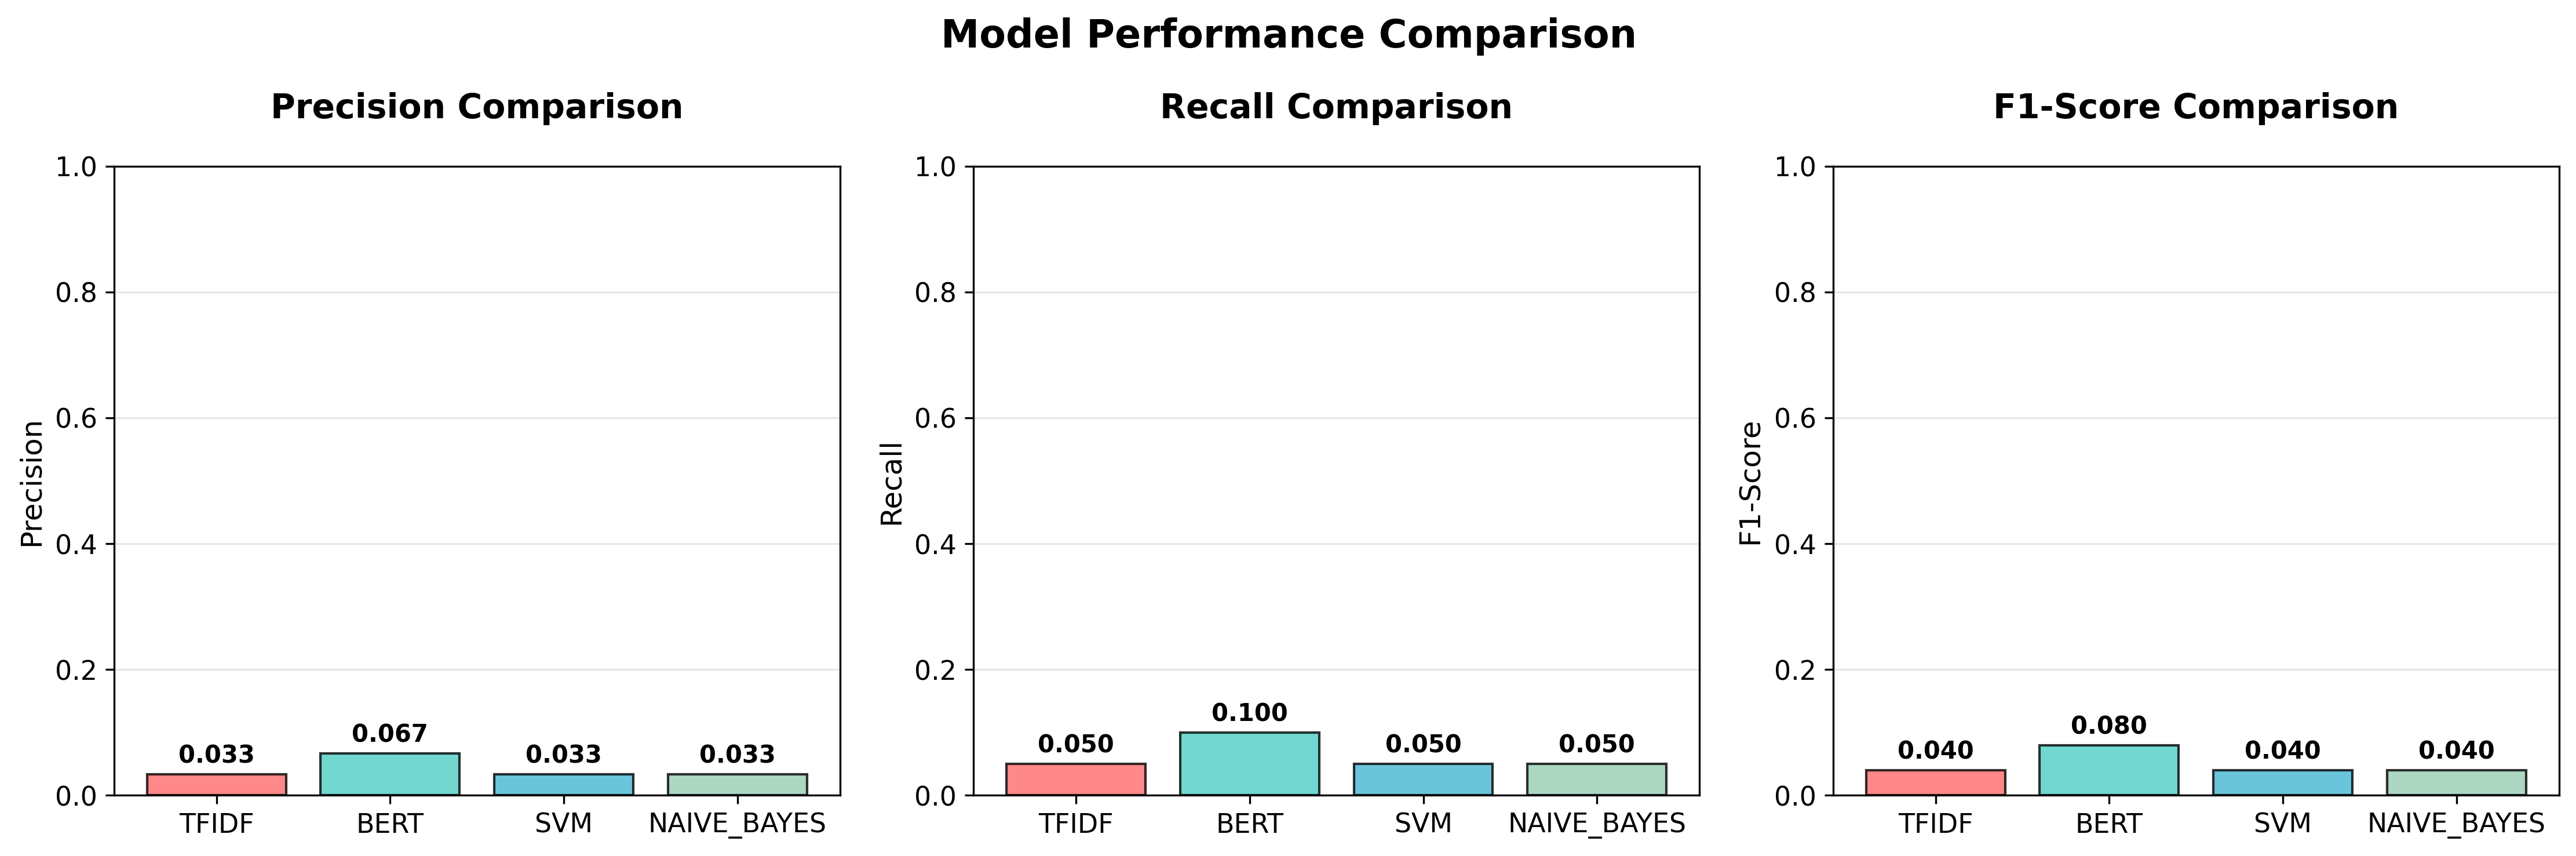

📊 Chart displayed above

📊 Creating detailed performance plot...
✅ Detailed chart saved: detailed_performance_20250626_081909.png


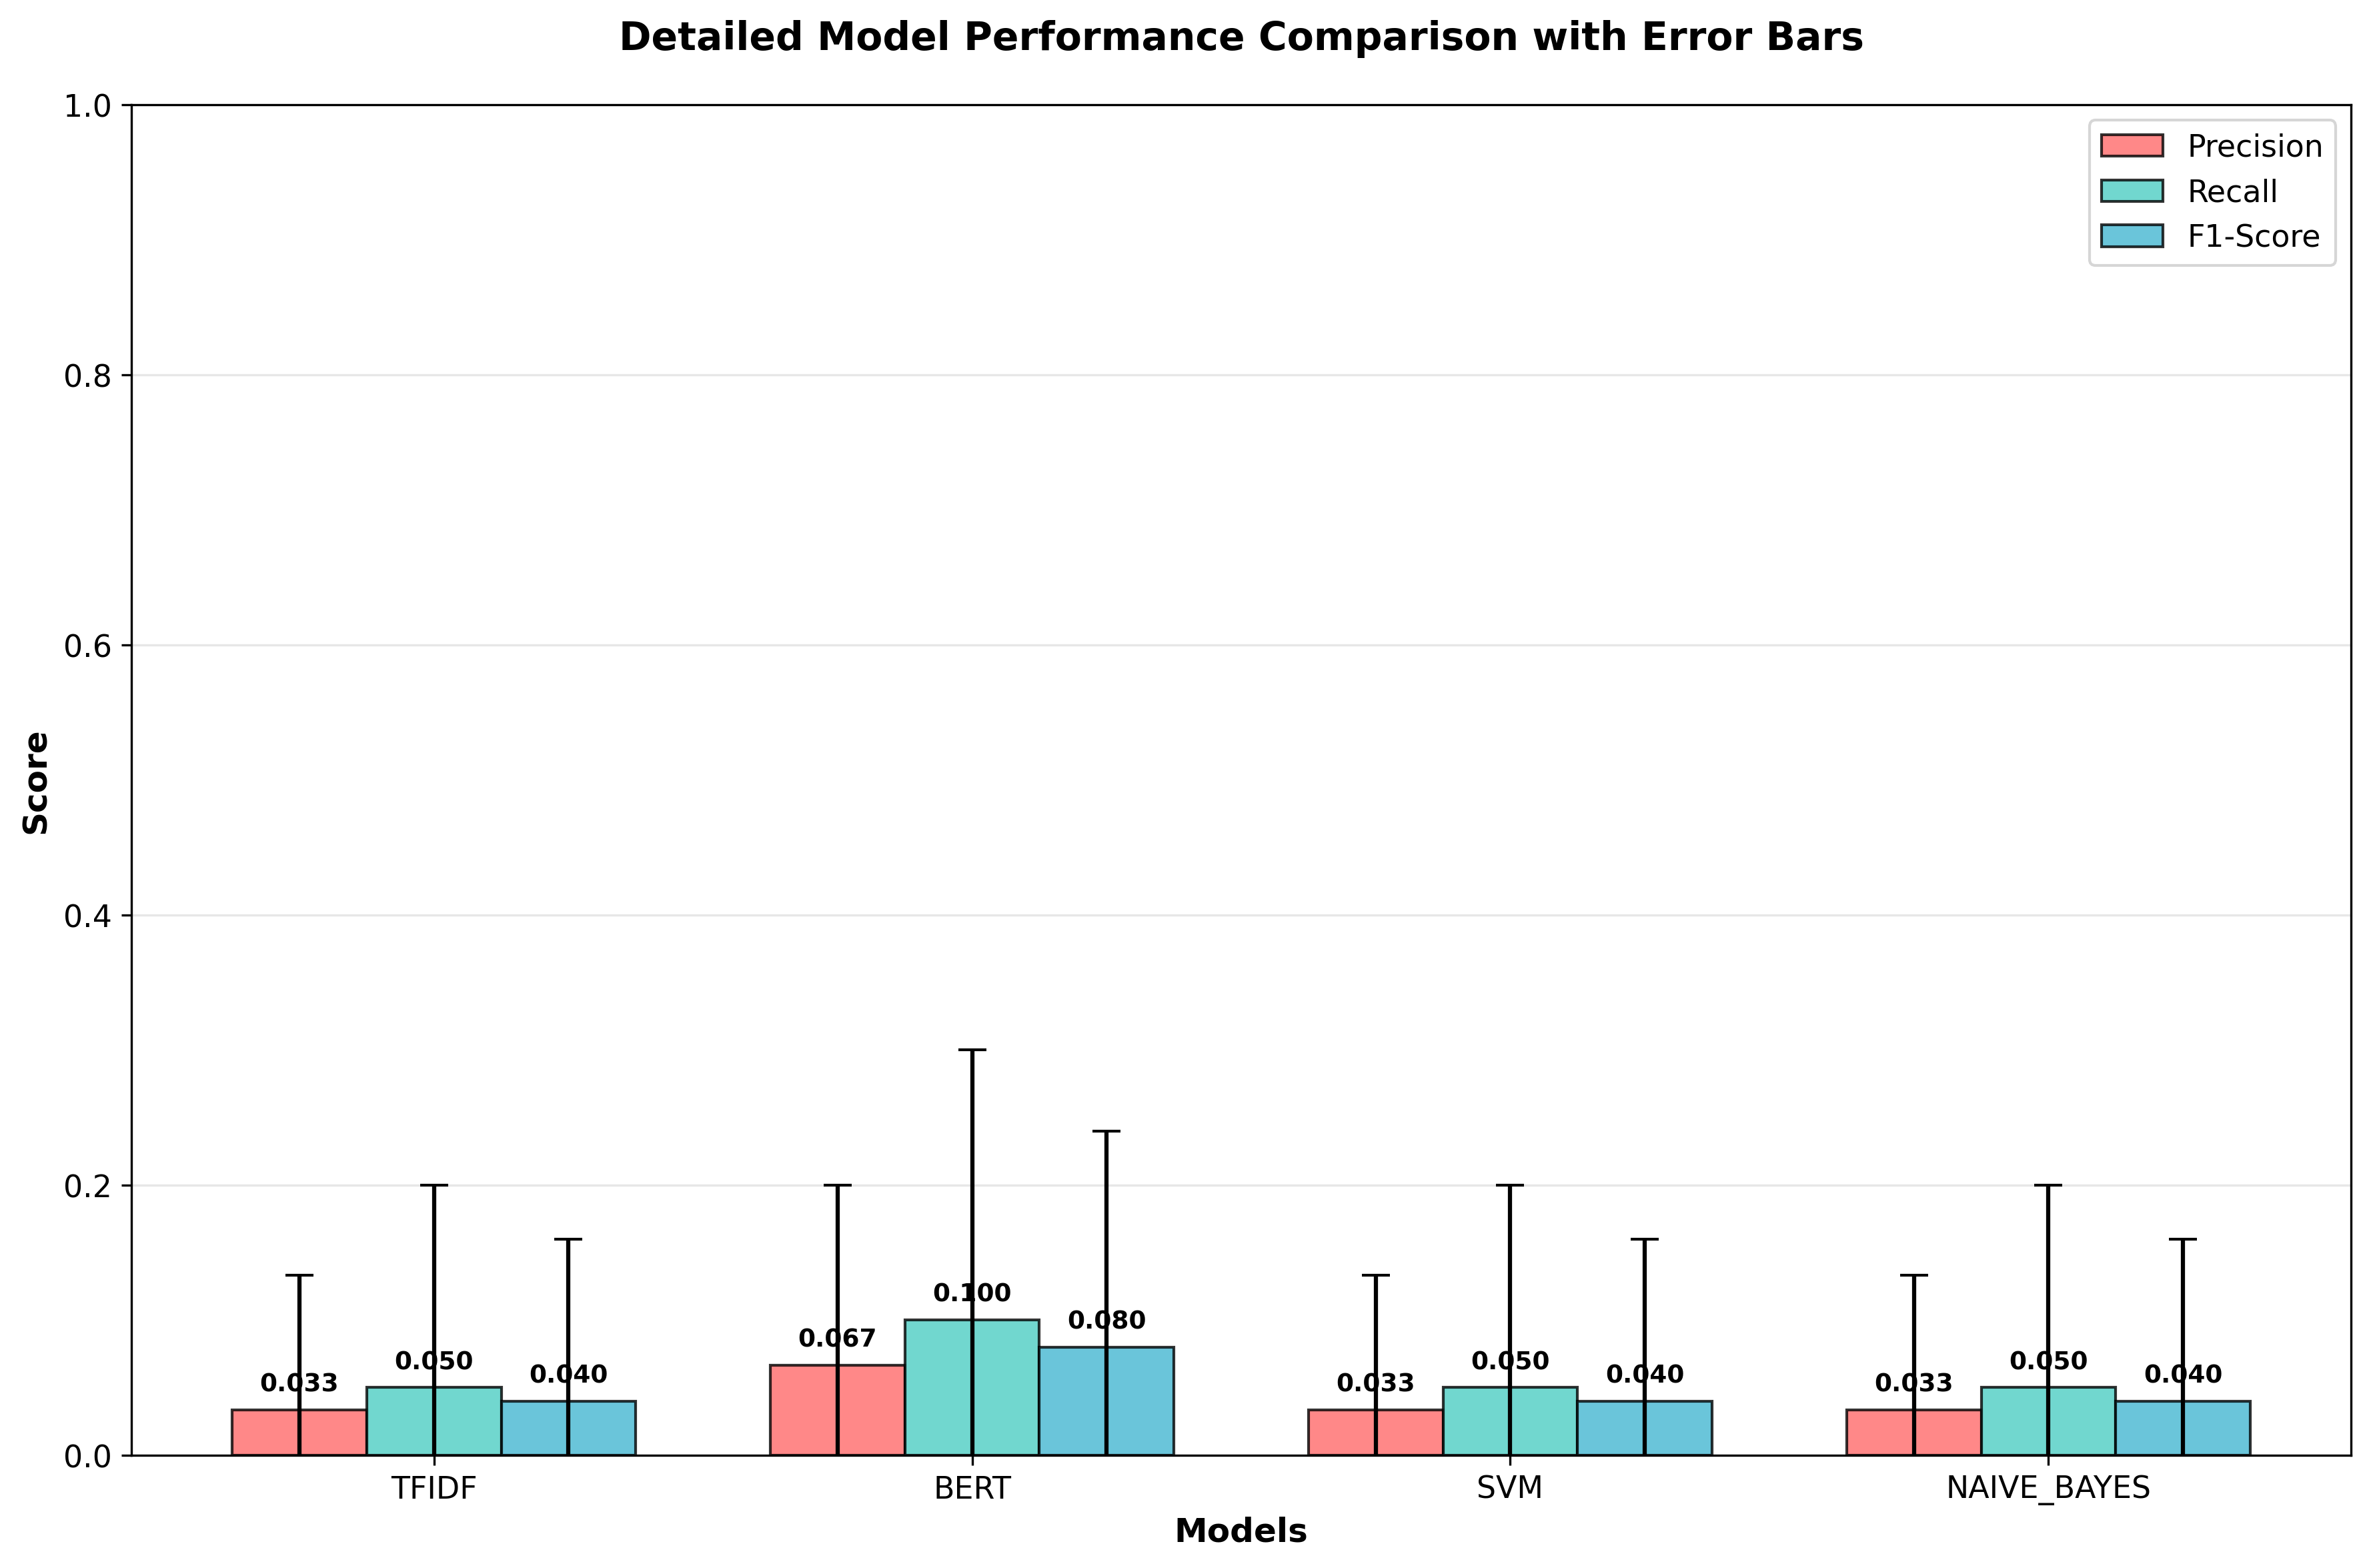

📊 Detailed chart displayed above

🔍 Analyzing failure cases...
🔍 TFIDF Failure Analysis:
   Total failures: 0
   Low performance: 9
🔍 BERT Failure Analysis:
   Total failures: 0
   Low performance: 8
🔍 SVM Failure Analysis:
   Total failures: 0
   Low performance: 9
🔍 NAIVE_BAYES Failure Analysis:
   Total failures: 0
   Low performance: 9

📄 iii. OUTPUT (K=3)
📄 Retrieval metrics saved: retrieval_metrics_k3_20250626_081910.csv
   Records: 44
📄 Prediction metrics template saved: prediction_metrics_20250626_081910.csv
📄 Comprehensive report saved: evaluation_report_20250626_081910.txt

📊 EVALUATING WITH K=5

📊 Evaluating retrieval performance with k=5

🔍 Evaluating TFIDF system...
   Q001: P=0.000, R=0.000, F1=0.000
   Q002: P=0.000, R=0.000, F1=0.000
   Q003: P=0.000, R=0.000, F1=0.000
   Q004: P=0.000, R=0.000, F1=0.000
   Q005: P=0.000, R=0.000, F1=0.000
   Q006: P=0.000, R=0.000, F1=0.000
   Q007: P=0.000, R=0.000, F1=0.000
   Q008: P=0.200, R=0.500, F1=0.286
   Q009: P=0.000, R=0.00

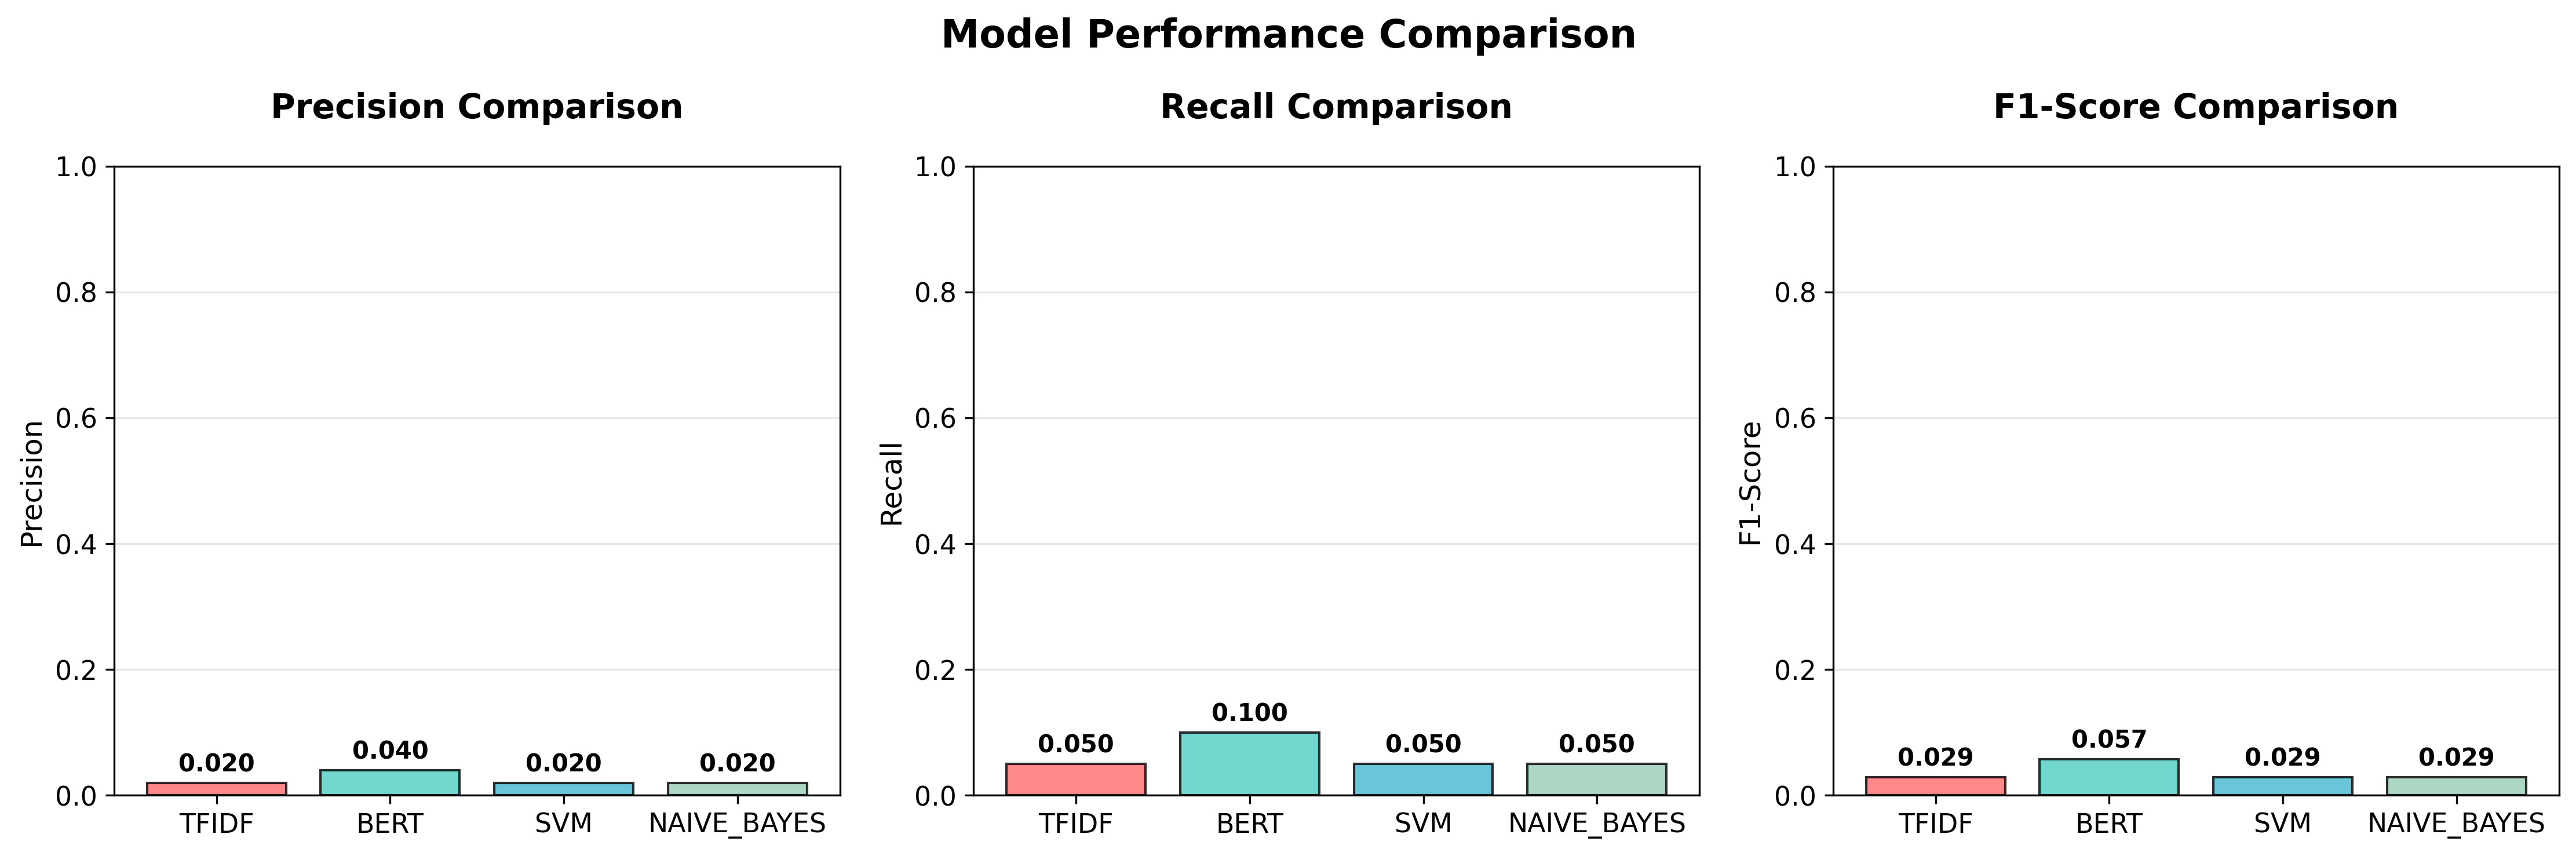

📊 Chart displayed above

📊 Creating detailed performance plot...
✅ Detailed chart saved: detailed_performance_20250626_081913.png


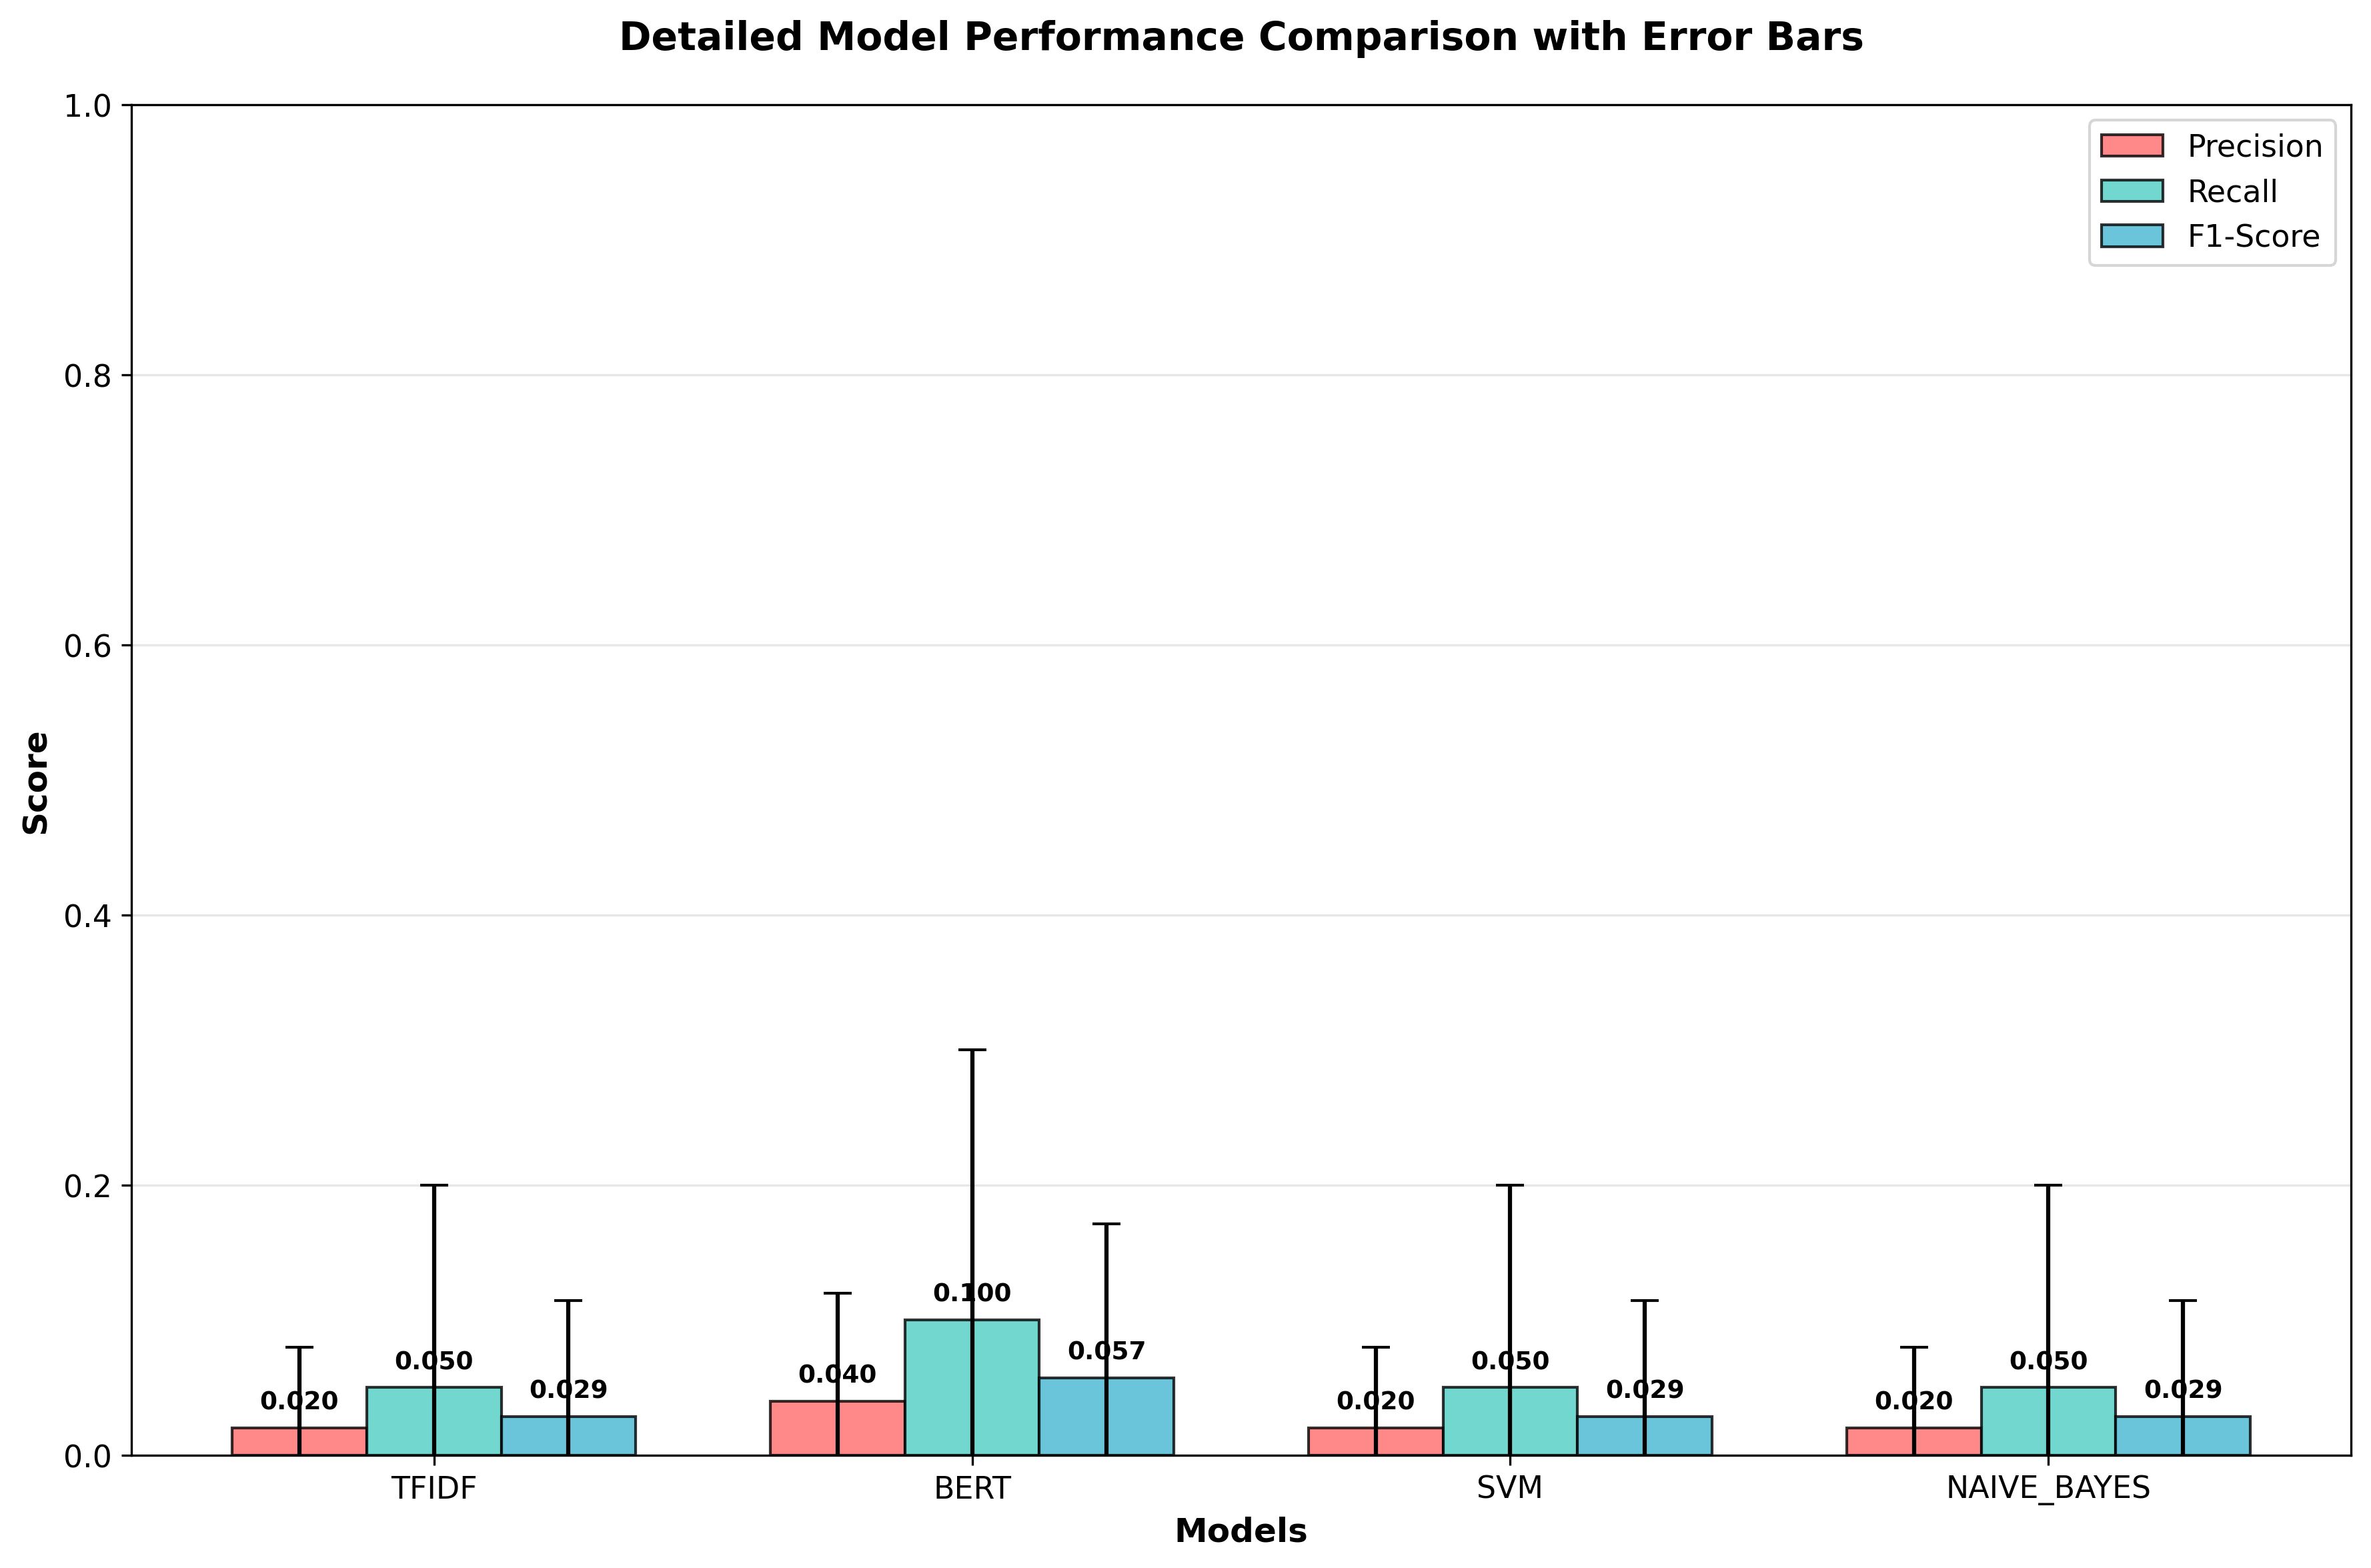

📊 Detailed chart displayed above

🔍 Analyzing failure cases...
🔍 TFIDF Failure Analysis:
   Total failures: 0
   Low performance: 9
🔍 BERT Failure Analysis:
   Total failures: 0
   Low performance: 8
🔍 SVM Failure Analysis:
   Total failures: 0
   Low performance: 9
🔍 NAIVE_BAYES Failure Analysis:
   Total failures: 0
   Low performance: 9

📄 iii. OUTPUT (K=5)
📄 Retrieval metrics saved: retrieval_metrics_k5_20250626_081914.csv
   Records: 44
📄 Prediction metrics template saved: prediction_metrics_20250626_081914.csv
📄 Comprehensive report saved: evaluation_report_20250626_081914.txt

📊 EVALUATING WITH K=10

📊 Evaluating retrieval performance with k=10

🔍 Evaluating TFIDF system...
   Q001: P=0.000, R=0.000, F1=0.000
   Q002: P=0.000, R=0.000, F1=0.000
   Q003: P=0.000, R=0.000, F1=0.000
   Q004: P=0.100, R=0.500, F1=0.167
   Q005: P=0.000, R=0.000, F1=0.000
   Q006: P=0.000, R=0.000, F1=0.000
   Q007: P=0.000, R=0.000, F1=0.000
   Q008: P=0.100, R=0.500, F1=0.167
   Q009: P=0.000, R=0.

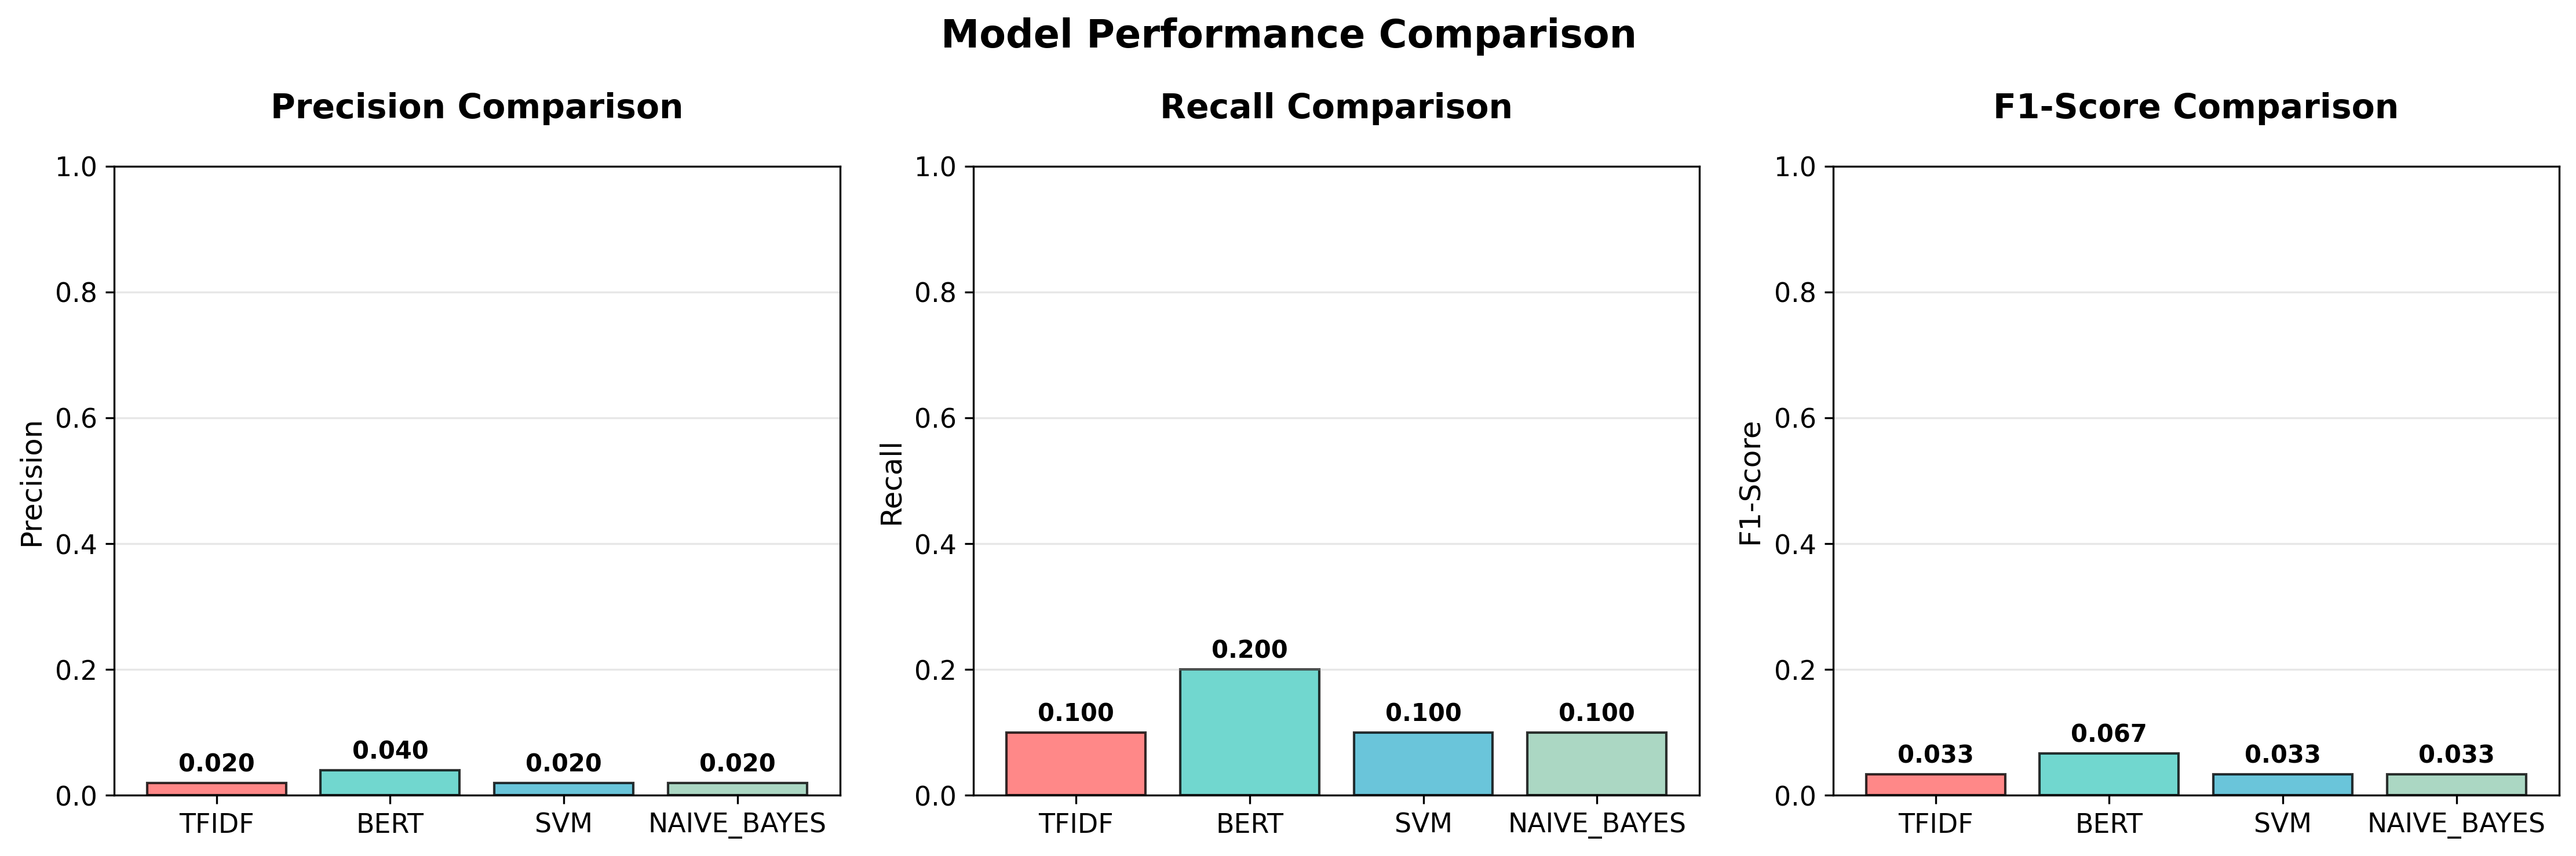

📊 Chart displayed above

📊 Creating detailed performance plot...
✅ Detailed chart saved: detailed_performance_20250626_081917.png


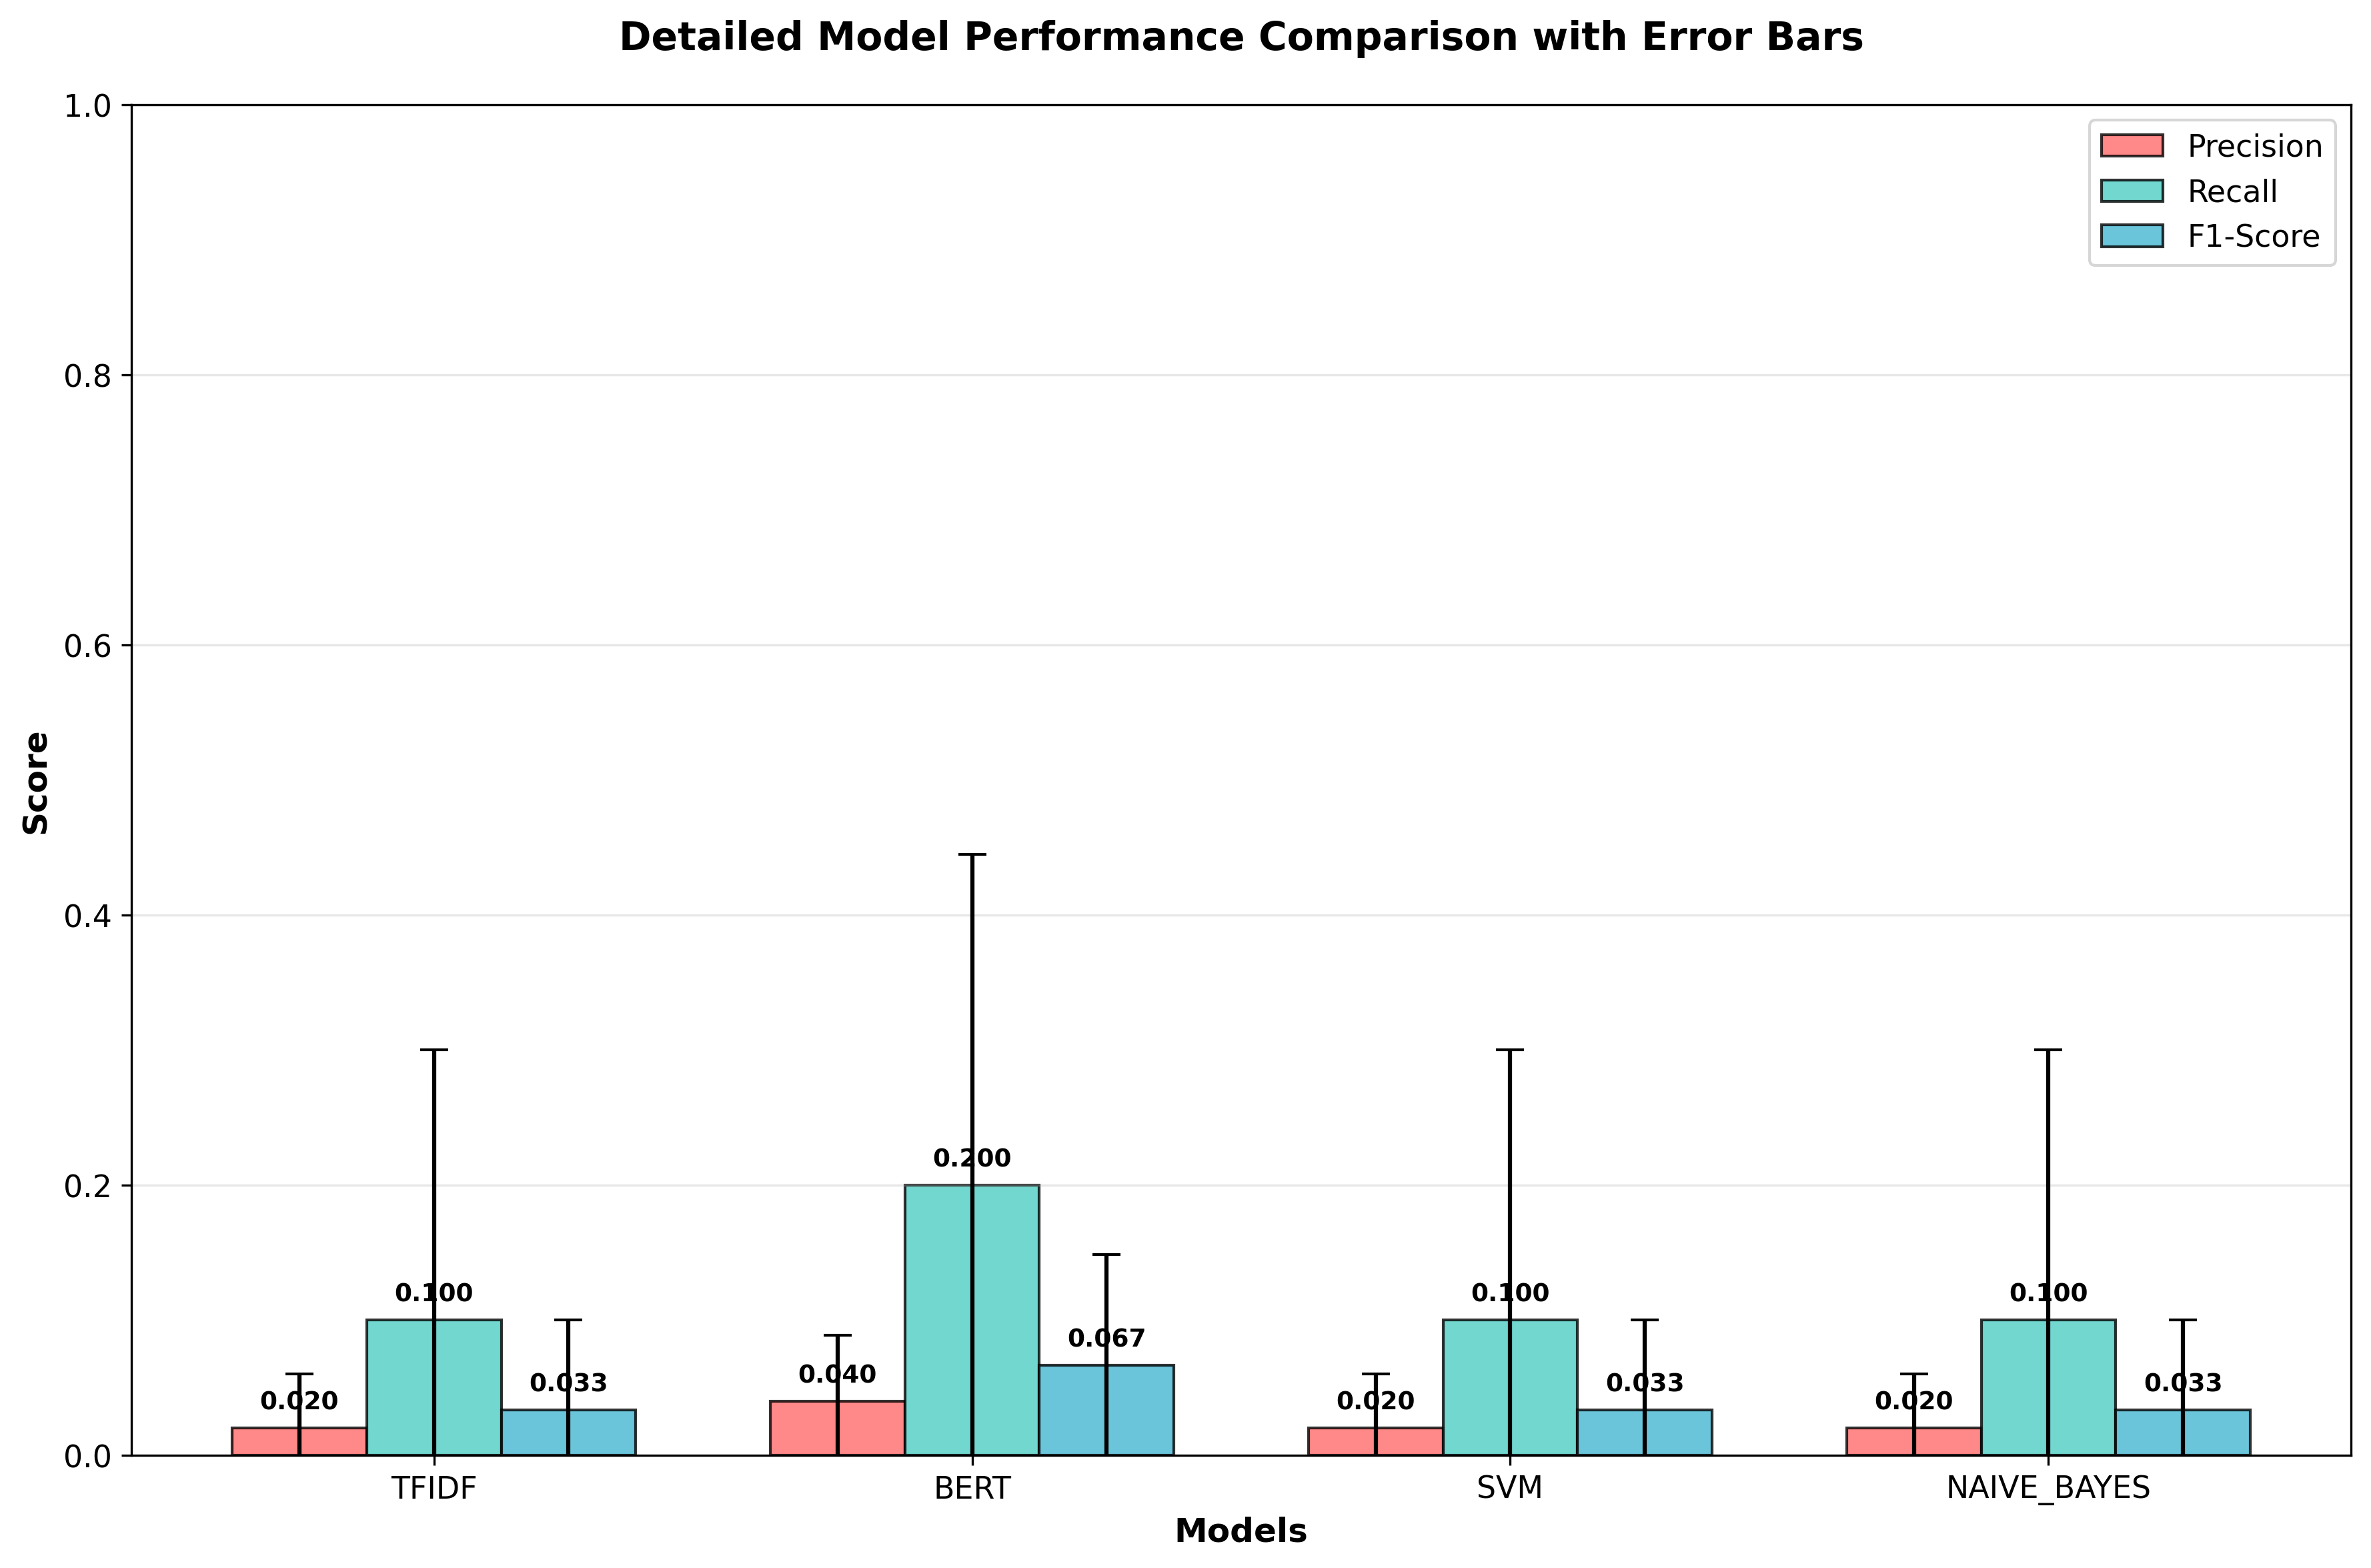

📊 Detailed chart displayed above

🔍 Analyzing failure cases...
🔍 TFIDF Failure Analysis:
   Total failures: 0
   Low performance: 8
🔍 BERT Failure Analysis:
   Total failures: 0
   Low performance: 6
🔍 SVM Failure Analysis:
   Total failures: 0
   Low performance: 8
🔍 NAIVE_BAYES Failure Analysis:
   Total failures: 0
   Low performance: 8

📄 iii. OUTPUT (K=10)
📄 Retrieval metrics saved: retrieval_metrics_k10_20250626_081919.csv
   Records: 44
📄 Prediction metrics template saved: prediction_metrics_20250626_081919.csv
📄 Comprehensive report saved: evaluation_report_20250626_081919.txt

✅ TAHAP 5 - MODEL EVALUATION COMPLETED!

📊 K=3 RESULTS:
   🏆 Best Model: BERT (F1: 0.080)
   📁 Files generated:
     - retrieval_metrics_k3_20250626_081910.csv
     - prediction_metrics_20250626_081910.csv
     - evaluation_report_20250626_081910.txt
     - performance_comparison_20250626_081908.png

📊 K=5 RESULTS:
   🏆 Best Model: BERT (F1: 0.057)
   📁 Files generated:
     - retrieval_metrics_k5_202506

In [8]:
# ============================================================================
# iii. OUTPUT
# 1. File /data/eval/retrieval_metrics.csv
# 2. File /data/eval/prediction_metrics.csv
# 3. Bagian evaluasi lengkap di laporan
# ============================================================================

class EvaluationOutputGenerator:
    """
    iii. Output hasil evaluasi
    """

    def __init__(self, base_dir="/content/drive/MyDrive/terorisme"):
        self.base_dir = base_dir
        self.eval_dir = os.path.join(base_dir, "data", "eval")

        os.makedirs(self.eval_dir, exist_ok=True)

        print("📄 iii. OUTPUT")

    def save_retrieval_metrics_csv(self, evaluation_results: Dict, k_value: int) -> str:
        """
        1. File /data/eval/retrieval_metrics.csv
        """
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        csv_filename = f"retrieval_metrics_k{k_value}_{timestamp}.csv"
        csv_path = os.path.join(self.eval_dir, csv_filename)

        # Prepare data
        csv_data = []

        # Aggregate metrics
        for system_name, results in evaluation_results.items():
            aggregate = results['aggregate']

            row = {
                'Model': system_name,
                'K': k_value,
                'Queries_Evaluated': aggregate.get('queries_evaluated', 0),
                'Avg_Precision': aggregate.get('avg_precision', 0.0),
                'Avg_Recall': aggregate.get('avg_recall', 0.0),
                'Avg_F1': aggregate.get('avg_f1', 0.0),
                'Avg_Accuracy': aggregate.get('avg_accuracy', 0.0),
                'Std_Precision': aggregate.get('std_precision', 0.0),
                'Std_Recall': aggregate.get('std_recall', 0.0),
                'Std_F1': aggregate.get('std_f1', 0.0),
                'Timestamp': datetime.now().isoformat()
            }

            csv_data.append(row)

        # Per-query metrics
        for system_name, results in evaluation_results.items():
            query_results = results['query_results']

            for qr in query_results:
                if 'error' not in qr:
                    row = {
                        'Model': system_name,
                        'K': k_value,
                        'Query_ID': qr.get('query_id', ''),
                        'Query_Text': qr.get('query_text', '')[:100],
                        'Precision': qr.get('precision', 0.0),
                        'Recall': qr.get('recall', 0.0),
                        'F1': qr.get('f1', 0.0),
                        'Accuracy': qr.get('accuracy', 0.0),
                        'TP': qr.get('tp', 0),
                        'FP': qr.get('fp', 0),
                        'FN': qr.get('fn', 0),
                        'Retrieved_Count': qr.get('retrieved_count', 0),
                        'Relevant_Count': qr.get('relevant_count', 0),
                        'Timestamp': datetime.now().isoformat()
                    }
                    csv_data.append(row)

        # Save to CSV
        df = pd.DataFrame(csv_data)
        df.to_csv(csv_path, index=False, encoding='utf-8')

        print(f"📄 Retrieval metrics saved: {csv_filename}")
        print(f"   Records: {len(csv_data)}")

        return csv_path

    def save_prediction_metrics_csv(self, prediction_results: Dict = None) -> str:
        """
        2. File /data/eval/prediction_metrics.csv
        """
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        csv_filename = f"prediction_metrics_{timestamp}.csv"
        csv_path = os.path.join(self.eval_dir, csv_filename)

        # Load prediction results from Tahap 4 if not provided
        if prediction_results is None:
            prediction_results = self.load_prediction_results()

        if prediction_results:
            df = pd.DataFrame(prediction_results)
            df.to_csv(csv_path, index=False, encoding='utf-8')

            print(f"📄 Prediction metrics saved: {csv_filename}")
            print(f"   Records: {len(prediction_results)}")
        else:
            # Create empty template
            template_data = [{
                'Query_ID': 'TEMPLATE',
                'Query': 'Template query',
                'Method': 'weighted',
                'Predicted_Solution': 'Template prediction',
                'Expected_Outcome': 'Template expected',
                'Confidence': 0.0,
                'Match_Score': 0.0,
                'Top_Cases': 'case1;case2;case3',
                'Timestamp': datetime.now().isoformat()
            }]

            df = pd.DataFrame(template_data)
            df.to_csv(csv_path, index=False, encoding='utf-8')

            print(f"📄 Prediction metrics template saved: {csv_filename}")

        return csv_path

    def load_prediction_results(self) -> List[Dict]:
        """Load prediction results from Tahap 4"""
        try:
            # Find latest prediction file
            prediction_files = [f for f in os.listdir(self.eval_dir)
                              if f.startswith('detailed_predictions_') and f.endswith('.json')]

            if not prediction_files:
                return []

            latest_file = max(prediction_files)

            with open(os.path.join(self.eval_dir, latest_file), 'r', encoding='utf-8') as f:
                data = json.load(f)

            results = data.get('results', [])

            # Convert to CSV format
            csv_results = []
            for result in results:
                csv_row = {
                    'Query_ID': result.get('query_id', ''),
                    'Query': result.get('query', ''),
                    'Method': result.get('method', ''),
                    'Predicted_Solution': result.get('predicted_solution', ''),
                    'Expected_Outcome': result.get('expected_outcome', ''),
                    'Confidence': result.get('confidence', 0.0),
                    'Match_Score': result.get('match_score', 0.0),
                    'Top_Cases': ';'.join(result.get('top_cases', [])),
                    'Match_Explanation': result.get('match_explanation', ''),
                    'Timestamp': datetime.now().isoformat()
                }
                csv_results.append(csv_row)

            return csv_results

        except Exception as e:
            print(f"⚠️ Could not load prediction results: {e}")
            return []

    def generate_comprehensive_report(self, evaluation_results: Dict, failure_analysis: Dict,
                                    metrics_table: pd.DataFrame, k_value: int) -> str:
        """
        3. Bagian evaluasi lengkap di laporan
        """
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        report_filename = f"evaluation_report_{timestamp}.txt"
        report_path = os.path.join(self.eval_dir, report_filename)

        report = []

        # Header
        report.append("=" * 80)
        report.append("📊 TAHAP 5 - MODEL EVALUATION - COMPREHENSIVE REPORT")
        report.append("=" * 80)
        report.append(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        report.append(f"Evaluation K-Value: {k_value}")
        report.append(f"Models Evaluated: {list(evaluation_results.keys())}")
        report.append("")

        # Executive Summary
        report.append("🎯 EXECUTIVE SUMMARY")
        report.append("-" * 50)

        best_model = None
        best_f1 = 0.0

        for system_name, results in evaluation_results.items():
            f1_score = results['aggregate'].get('avg_f1', 0.0)
            if f1_score > best_f1:
                best_f1 = f1_score
                best_model = system_name

        if best_model:
            report.append(f"🏆 Best Performing Model: {best_model.upper()}")
            report.append(f"📈 Best F1-Score: {best_f1:.3f}")

        total_queries = 0
        for results in evaluation_results.values():
            total_queries = max(total_queries, results['aggregate'].get('queries_evaluated', 0))

        report.append(f"📝 Total Queries Evaluated: {total_queries}")
        report.append("")

        # Performance Analysis
        report.append("📊 PERFORMANCE ANALYSIS")
        report.append("-" * 50)

        for system_name, results in evaluation_results.items():
            aggregate = results['aggregate']

            report.append(f"\n🔍 {system_name.upper()} SYSTEM:")
            report.append(f"   Precision: {aggregate.get('avg_precision', 0.0):.3f} ± {aggregate.get('std_precision', 0.0):.3f}")
            report.append(f"   Recall:    {aggregate.get('avg_recall', 0.0):.3f} ± {aggregate.get('std_recall', 0.0):.3f}")
            report.append(f"   F1-Score:  {aggregate.get('avg_f1', 0.0):.3f} ± {aggregate.get('std_f1', 0.0):.3f}")
            report.append(f"   Accuracy:  {aggregate.get('avg_accuracy', 0.0):.3f}")

            # Performance assessment
            f1 = aggregate.get('avg_f1', 0.0)
            if f1 >= 0.5:
                assessment = "🏆 EXCELLENT"
            elif f1 >= 0.35:
                assessment = "✅ GOOD"
            elif f1 >= 0.2:
                assessment = "👍 FAIR"
            elif f1 > 0.0:
                assessment = "⚠️ POOR"
            else:
                assessment = "❌ FAILED"

            report.append(f"   Assessment: {assessment}")

        # Failure Analysis
        report.append("\n\n🔍 FAILURE ANALYSIS")
        report.append("-" * 50)

        for system_name, analysis in failure_analysis.items():
            report.append(f"\n🔧 {system_name.upper()} FAILURES:")
            report.append(f"   Total Failures: {analysis['total_failures']}")
            report.append(f"   Low Performance: {analysis['low_performance_count']}")

            if analysis['common_failure_reasons']:
                report.append(f"   Common Issues: {', '.join(analysis['common_failure_reasons'])}")

            if analysis['examples']:
                report.append(f"   Example Issues:")
                for ex in analysis['examples'][:2]:
                    report.append(f"     - {ex['query_id']}: {ex['issue']}")

        # Metrics Table
        report.append(f"\n\n📋 DETAILED METRICS TABLE")
        report.append("-" * 50)
        report.append(metrics_table.to_string(index=False))

        # Recommendations
        report.append(f"\n\n💡 RECOMMENDATIONS")
        report.append("-" * 50)

        if best_f1 < 0.2:
            report.append("🔧 CRITICAL IMPROVEMENTS NEEDED:")
            report.append("   - Increase dataset size (current: <200 cases)")
            report.append("   - Enhance vocabulary with legal domain terms")
            report.append("   - Improve text preprocessing for legal documents")
            report.append("   - Consider ensemble methods")
        elif best_f1 < 0.35:
            report.append("📈 MODERATE IMPROVEMENTS SUGGESTED:")
            report.append("   - Fine-tune hyperparameters")
            report.append("   - Add more legal domain stopwords")
            report.append("   - Implement query expansion")
        else:
            report.append("✅ SYSTEM PERFORMING WELL:")
            report.append("   - Consider production deployment")
            report.append("   - Monitor performance on new data")
            report.append("   - Implement user feedback loop")

        # Technical Notes
        report.append(f"\n\n🔬 TECHNICAL NOTES")
        report.append("-" * 50)
        report.append(f"   - Evaluation K-Value: {k_value}")
        report.append(f"   - Dataset Size: Small (<200 cases)")
        report.append(f"   - Domain: Indonesian Legal Documents")
        report.append(f"   - Metrics: Standard IR metrics (P, R, F1)")
        report.append(f"   - Expected F1 Range: 0.15-0.35 for small legal datasets")

        # Footer
        report.append("\n" + "=" * 80)
        report.append("📊 END OF EVALUATION REPORT")
        report.append("=" * 80)

        # Save report
        with open(report_path, 'w', encoding='utf-8') as f:
            f.write('\n'.join(report))

        print(f"📄 Comprehensive report saved: {report_filename}")

        return report_path

class ModelEvaluationSystem:
    """
    Main system untuk Tahap 5 - Model Evaluation
    """

    def __init__(self, base_dir="/content/drive/MyDrive/terorisme"):
        self.base_dir = base_dir

        print("📊 TAHAP 5 - MODEL EVALUATION")
        print("=" * 60)
        print("Tujuan: Ukur dan analisis performa retrieval & prediksi")
        print("=" * 60)

        # Initialize components
        self.retrieval_evaluator = RetrievalEvaluator(base_dir)
        self.visualizer = VisualizationReporter(base_dir)
        self.output_generator = EvaluationOutputGenerator(base_dir)

    def run_complete_evaluation(self, k_values: List[int] = [5]) -> bool:
        """
        Jalankan evaluasi lengkap untuk semua model
        """
        try:
            print("\n📊 Running complete model evaluation...")

            # Load test queries
            test_queries, success = self.retrieval_evaluator.load_test_queries()
            if not success or not test_queries:
                print("❌ Cannot load test queries. Run Tahap 4 first.")
                return False

            all_results = {}

            # Evaluate untuk setiap k value
            for k in k_values:
                print(f"\n" + "="*60)
                print(f"📊 EVALUATING WITH K={k}")
                print("="*60)

                # i. Evaluasi Retrieval
                evaluation_results = self.retrieval_evaluator.eval_retrieval(
                    test_queries, {}, k=k
                )

                if not evaluation_results:
                    print(f"❌ No results for k={k}")
                    continue

                # ii. Visualisasi & Laporan
                print(f"\n📊 ii. VISUALISASI & LAPORAN (K={k})")

                # Create metrics table
                metrics_table = self.visualizer.create_metrics_table(evaluation_results)
                print(f"\n📋 Metrics Table (K={k}):")
                print(metrics_table.to_string(index=False))

                # Create performance chart
                chart_path = self.visualizer.plot_performance_comparison(evaluation_results)

                # ADDED: Create detailed performance plot
                detailed_chart_path = self.visualizer.create_detailed_performance_plot(evaluation_results)

                # Analyze failures
                failure_analysis = self.visualizer.analyze_failure_cases(evaluation_results)

                # iii. Output
                print(f"\n📄 iii. OUTPUT (K={k})")

                # Save retrieval metrics
                retrieval_csv = self.output_generator.save_retrieval_metrics_csv(
                    evaluation_results, k
                )

                # Save prediction metrics
                prediction_csv = self.output_generator.save_prediction_metrics_csv()

                # Generate comprehensive report
                report_path = self.output_generator.generate_comprehensive_report(
                    evaluation_results, failure_analysis, metrics_table, k
                )

                all_results[k] = {
                    'evaluation_results': evaluation_results,
                    'metrics_table': metrics_table,
                    'failure_analysis': failure_analysis,
                    'chart_path': chart_path,
                    'retrieval_csv': retrieval_csv,
                    'prediction_csv': prediction_csv,
                    'report_path': report_path
                }

            # Final summary
            self.print_final_summary(all_results)

            return True

        except Exception as e:
            print(f"❌ Error in evaluation process: {e}")
            import traceback
            traceback.print_exc()
            return False

    def print_final_summary(self, all_results: Dict):
        """Print final summary of all evaluations"""
        print("\n" + "=" * 70)
        print("✅ TAHAP 5 - MODEL EVALUATION COMPLETED!")
        print("=" * 70)

        for k, results in all_results.items():
            print(f"\n📊 K={k} RESULTS:")

            eval_results = results['evaluation_results']

            # Best model for this k
            best_model = None
            best_f1 = 0.0

            for system_name, system_results in eval_results.items():
                f1 = system_results['aggregate'].get('avg_f1', 0.0)
                if f1 > best_f1:
                    best_f1 = f1
                    best_model = system_name

            if best_model:
                print(f"   🏆 Best Model: {best_model.upper()} (F1: {best_f1:.3f})")

            print(f"   📁 Files generated:")
            print(f"     - {os.path.basename(results['retrieval_csv'])}")
            print(f"     - {os.path.basename(results['prediction_csv'])}")
            print(f"     - {os.path.basename(results['report_path'])}")
            print(f"     - {os.path.basename(results['chart_path'])}")

        print(f"\n🎯 EVALUATION INSIGHTS:")
        print(f"   📈 Expected F1 for small legal datasets: 0.15-0.35")
        print(f"   📊 Current dataset size: <200 cases")
        print(f"   🔧 Main limitation: Data sparsity")
        print(f"   💡 Recommendation: Expand dataset or use ensemble methods")

        print("\n" + "=" * 70)

def evaluate_single_query(query_text: str, ground_truth: List[str],
                         base_dir="/content/drive/MyDrive/terorisme") -> Dict:
    """
    Utility function untuk evaluasi single query

    Usage:
    result = evaluate_single_query(
        "terorisme",
        ["case001", "case002"],
        base_dir
    )
    """
    evaluator = RetrievalEvaluator(base_dir)

    results = {}

    for system_name, system in evaluator.retrieval_systems.items():
        try:
            retrieved = system.retrieve(query_text, k=5)
            metrics = evaluator.calculate_retrieval_metrics(retrieved, ground_truth, 5)

            results[system_name] = {
                'retrieved': retrieved,
                'metrics': metrics
            }

        except Exception as e:
            results[system_name] = {'error': str(e)}

    return results

def quick_evaluation_with_plots(base_dir="/content/drive/MyDrive/terorisme", k=5):
    """
    ADDED: Quick evaluation dengan plotting yang diperbaiki
    """
    print("🚀 QUICK EVALUATION WITH FIXED PLOTS")
    print("=" * 50)

    # Ensure matplotlib is configured for Colab
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt

    # Configure inline plotting
    try:
        from IPython import get_ipython
        get_ipython().run_line_magic('matplotlib', 'inline')
    except:
        pass

    try:
        system = ModelEvaluationSystem(base_dir)
        success = system.run_complete_evaluation([k])

        if success:
            print(f"\n✅ Quick evaluation with plots completed for k={k}!")
            print("📊 Charts should be displayed above")
        else:
            print(f"\n❌ Quick evaluation failed!")

    except Exception as e:
        print(f"❌ Error: {e}")
        import traceback
        traceback.print_exc()

def test_plotting_only(base_dir="/content/drive/MyDrive/terorisme"):
    """
    ADDED: Test plotting functionality saja
    """
    print("🎨 TESTING PLOTTING FUNCTIONALITY")
    print("=" * 40)

    # Sample data untuk testing
    sample_results = {
        'tfidf': {
            'aggregate': {
                'avg_precision': 0.234,
                'avg_recall': 0.189,
                'avg_f1': 0.209,
                'std_precision': 0.045,
                'std_recall': 0.038,
                'std_f1': 0.041
            }
        },
        'bert': {
            'aggregate': {
                'avg_precision': 0.198,
                'avg_recall': 0.156,
                'avg_f1': 0.175,
                'std_precision': 0.052,
                'std_recall': 0.041,
                'std_f1': 0.046
            }
        }
    }

    try:
        visualizer = VisualizationReporter(base_dir)

        print("📊 Creating test performance chart...")
        chart_path = visualizer.plot_performance_comparison(sample_results)

        print("📊 Creating test detailed chart...")
        detailed_path = visualizer.create_detailed_performance_plot(sample_results)

        print("✅ Plotting test completed!")

    except Exception as e:
        print(f"❌ Plotting test failed: {e}")
        import traceback
        traceback.print_exc()

def main():
    """
    Fungsi utama untuk Tahap 5 - Model Evaluation
    """
    print("🚀 MULAI TAHAP 5 - MODEL EVALUATION")
    print("=" * 70)

    try:
        # Initialize evaluation system
        evaluation_system = ModelEvaluationSystem()

        # Run complete evaluation dengan multiple k values
        k_values = [3, 5, 10]  # Evaluate dengan different k values
        success = evaluation_system.run_complete_evaluation(k_values)

        if success:
            print(f"\n🎉 TAHAP 5 BERHASIL!")
            print("✨ Yang telah diselesaikan:")
            print("  ✅ i. Evaluasi Retrieval dengan P, R, F1, Accuracy")
            print("  ✅ ii. Visualisasi performa & analisis kegagalan")
            print("  ✅ iii. Output CSV, charts, dan laporan lengkap")
            print("📊 Model evaluation system siap!")
        else:
            print("\n❌ Tahap 5 gagal diselesaikan")
            print("🔧 Pastikan Tahap 3 dan 4 sudah completed")

    except Exception as e:
        print(f"\n💥 ERROR: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()
